# Notebook configuration

In [1]:
run_number          = 4520
filename_pattern    = "/Users/Gonzalo/github/NEXTdata/Na22/{}/pmaps*.h5".format(run_number)
outputfolder        = "Na/"
plots_format        = "pdf"
corr_pitch          = 5.4 # 4.0, 5.4, 8.1, 16.5
correction_filename = "/Users/Gonzalo/github/ICARO/icaro/KrMay/run4446_corrections_{}mm.h5".format(corr_pitch)
LT, u_LT            = 1100, 50
reco_algorithm_name = "barycenter"

S12filter     = True
zfilter       = False
lfilter       = False
rfilter       = False
nmin, nmax    =    1, 2
zmin, zmax    =    0, 400
lmin, lmax    =    0, 100
rmin, rmax    =    0, 200
corona_opts   = { # these values are probably not optimal
    "Qthr"          :  2,
    "Qlm"           : 10,
    "lm_radius"     : 20,
    "new_lm_radius" : 25,
    "msipm"         :  6,
}

rebin_min, \
rebin_max  = 1, 20

full_range =     0, 165e3
XR_range   =   4e3,  12e3
PP_range   = 130e3, 165e3

XR_fit_range =  8200, 12000
PP_fit_range = 136e3, 160e3

XR1_fit_seed =  8500
XR2_fit_seed = 10000
PP1_fit_seed = 155e3
PP2_fit_seed = 144e3

XR1_energy_keV = 29.7
XR2_energy_keV = 33.8

PP1_energy_keV = 511
PP2_energy_keV = PP1_energy_keV - XR1_energy_keV

Qbb_energy_keV = 2458

# Imports

In [2]:
import os
import glob
import functools
import itertools

import numpy             as     np
import matplotlib.pyplot as     plt
from   matplotlib.colors import LogNorm

import invisible_cities.core    .fit_functions     as     fitf
import invisible_cities.io      .pmap_io           as     pmpio
import invisible_cities.database.load_db           as     db

from   invisible_cities.core    .system_of_units_c import units
from   invisible_cities.reco    .dst_functions     import load_xy_corrections
from   invisible_cities.reco    .corrections       import LifetimeCorrection
from   invisible_cities.reco    .xy_algorithms     import barycenter
from   invisible_cities.reco    .xy_algorithms     import corona
from   invisible_cities.types   .ic_types          import xy

from   invisible_cities.icaro   .hst_functions     import hist
from   invisible_cities.icaro   .hst_functions     import hist2d
from   invisible_cities.icaro   .hst_functions     import resolution
from   invisible_cities.icaro   .hst_functions     import measurement_string
from   invisible_cities.icaro   .hst_functions     import poisson_sigma
from   invisible_cities.icaro   .hst_functions     import gausstext
from   invisible_cities.icaro   .hst_functions     import labels
from   invisible_cities.icaro   .hst_functions     import plot_writer

# Plotting options

In [3]:
%matplotlib inline
np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"         ] = 18, 12
plt.rcParams["figure.max_open_warning"] = 100
plt.rcParams["font.size"              ] = 25

data1_draw_opt      = "mp"
data2_draw_opt      = "cp"
bkg_fit_draw_opt    = "g-"
global_fit_draw_opt = "r-"
peak_1_fit_draw_opt = "k-"
peak_2_fit_draw_opt = "b-"

# Initialization

In [4]:
filenames      = glob.glob(filename_pattern)
XYcorrection   = load_xy_corrections(correction_filename)
LTcorrection   = LifetimeCorrection(LT, u_LT)
save           = plot_writer(outputfolder, plots_format)
reco_algorithm = functools.partial(corona, **corona_opts) if reco_algorithm_name == "corona" else barycenter

full_range_bins = np.linspace(*full_range, 1000)
XR_range_bins   = np.linspace(*  XR_range,  100)
PP_range_bins   = np.linspace(*  PP_range,  100)

full_bin_size   = np.diff(full_range_bins)[0]
XR_bin_size     = np.diff(  XR_range_bins)[0]
PP_bin_size     = np.diff(  PP_range_bins)[0]

rebin_values    = np.arange(rebin_min, rebin_max + 1)

resolution_xr   = {}
resolution_pp   = {}

u_resolution_xr = {}
u_resolution_pp = {}

resolution_at_xr_string  = "Resolution at {: <4} keV:".format(XR1_energy_keV)
resolution_at_pp_string  = "Resolution at {: <4} keV:".format(PP1_energy_keV)
resolution_at_qbb_string = "Resolution at {: <4} keV:".format(Qbb_energy_keV)
chi2_string              = "Chi2{}:".format(" "*18) 

# Functions

In [5]:
def merge_dicts(args):
    output = {}
    list(map(output.update, args))
    return output

def filter_dict(D, valid_keys):
    return dict(filter(lambda x: x[0] in valid_keys, D.items()))

def npeaks(S):
    return S.number_of_peaks

def sum_raw_ene(s2):
    return [peak.E.sum() for peak in s2.peaks.values()]

def rebin(arr, n_rebin, op=np.sum):
    n_bins = int(np.ceil(arr.size/n_rebin))
    return np.array([op(arr[i*n_rebin:(i+1)*n_rebin]) for i in range(n_bins)])

def get_s1_time(s1):
    wf = s1.peak_waveform(0)
    return wf.t[np.argmax(wf.E)]

def keys_and_values(dictionary, output_type=np.array):
    return list(map(output_type, zip(*dictionary.items())))

def map_and_chain(*args, **kwargs):
    return np.array(list(itertools.chain.from_iterable(map(*args, **kwargs))))

def pos_sipm(IDs):
    return np.stack((datasipm.X.values[IDs],
                     datasipm.Y.values[IDs]),
                    axis = 1)

def correct_peaks_ene(s1, s2, si, n_rebin=1, reco_algorithm=barycenter):
    Ecorr   = []
    s1_time = get_s1_time(s1)
    for peak_no in s2.peak_collection():
        wf      = s2.peak_waveform(peak_no)
        si_peak = si.s2sid[peak_no]
        nslices = int(np.ceil(wf.t.size/n_rebin))

        t = rebin(wf.t, n_rebin, op=np.mean)
        E = rebin(wf.E, n_rebin, op=np.sum )
        Q = { sipm : rebin(q, n_rebin, op=np.sum) for sipm, q in si_peak.items()}
        Q = [{sipm : (qs[i] if i < len(qs) else 0) for sipm, qs in Q.items()} for i in range(nslices)]

        contained = True
        E_peak    = 0
        for i in range(nslices):
            Z  = (t[i] - s1_time) / units.mus
            e0 =  E[i] * LTcorrection(Z).value

            if zfilter and not zmin <= Z < zmax:
                contained = False
                break
            
            sipm_IDs,\
            sipm_Qs  = keys_and_values(Q[i])

            # in case of empty TP response, add raw energy
            if np.sum(sipm_Qs) <= 0:
                E_peak += e0
                continue

            sipm_pos = pos_sipm(sipm_IDs)
            clusters = reco_algorithm(sipm_pos, sipm_Qs)

            e = 0
            for cluster in clusters:
                if rfilter and (cluster.X**2 + cluster.Y**2)**0.5 > rmax:
                    contained = False
                    break
                e += cluster.Q * XYcorrection(cluster.X, cluster.Y).value[0]

            if not contained:
                break
            
            E_peak += e * e0/sum(cluster.Q for cluster in clusters)
        
        if contained:
            Ecorr.append(E_peak)
    return Ecorr

def correct_evt_ene(n_rebin=1, reco_algorithm=barycenter):
    print("Running rebin value", n_rebin)
    return functools.partial(correct_peaks_ene,
                             n_rebin        = n_rebin,
                             reco_algorithm = reco_algorithm) 

# Load PMaps

Total    # events = 61673
Valid    # events = 59573. Ratio = 96.6 %
Selected # events = 54110. Ratio = 87.7 %


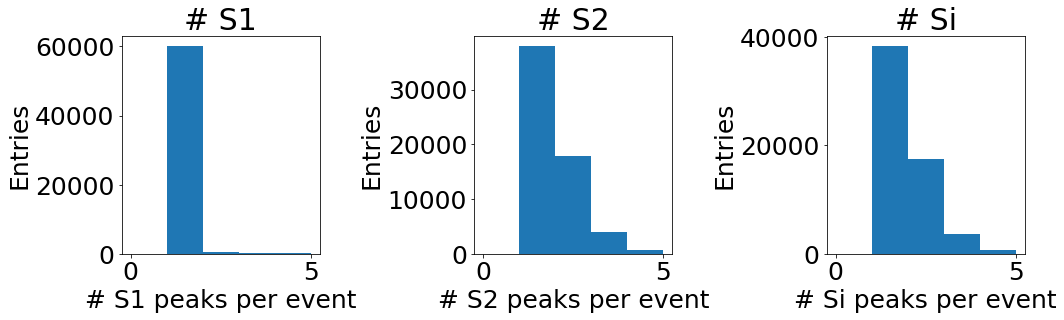

In [6]:
s1s, s2s, sis = map(merge_dicts, zip(*map(pmpio.load_pmaps, filenames)))
datasipm      = db.DataSiPM(run_number)

plt.figure(figsize=(15,5))
for i, (name, S) in enumerate(zip(["S1", "S2", "Si"],
                                  [ s1s,  s2s,  sis])):
    plt.subplot(1, 3, 1+i)
    plt.hist(list(map(npeaks, S.values())), np.arange(6))
    labels("# {} peaks per event".format(name), "Entries" , "# {}".format(name))
plt.tight_layout()

evt_nos_all   = set(s1s.keys()) | set(s2s.keys()) | set(sis.keys())
evt_nos_valid = set(s1s.keys()) & set(s2s.keys()) & set(sis.keys()) # Ensure at least one S1 and one S2 (both in PMTs and SiPMs) are present

if S12filter: # Get those events with exactly one S1 and [nmin, nmax] S2s
    evt_nos_selected   = list(filter(lambda evt:         npeaks(s1s[evt]) == 1 and \
                                                 nmin <= npeaks(s2s[evt]) == \
                                                         npeaks(sis[evt]) <= nmax, evt_nos_valid))

print("Total    # events =", len(evt_nos_all))
print("Valid    # events = {}. Ratio = {:.1f} %".format(len(evt_nos_valid   ), 100 * len(evt_nos_valid   ) / len(evt_nos_all)))
print("Selected # events = {}. Ratio = {:.1f} %".format(len(evt_nos_selected), 100 * len(evt_nos_selected) / len(evt_nos_all)))

s1s = filter_dict(s1s, evt_nos_selected)
s2s = filter_dict(s2s, evt_nos_selected)
sis = filter_dict(sis, evt_nos_selected)

# Raw spectrum

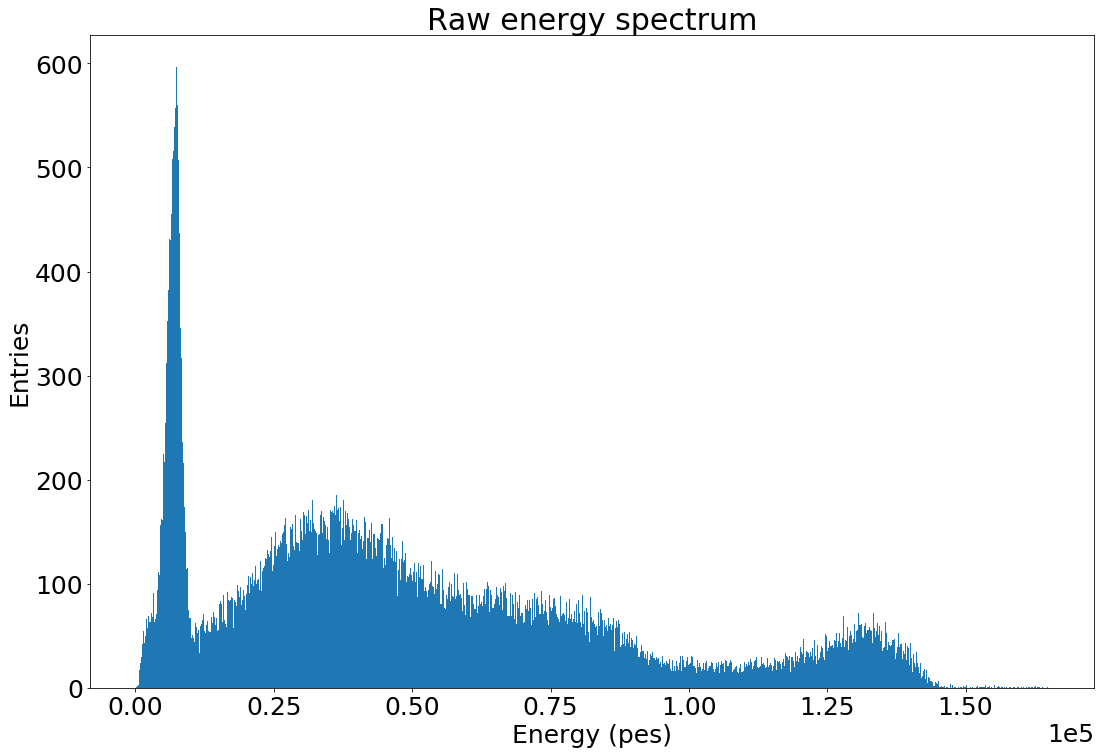

In [7]:
E_raw = map_and_chain(sum_raw_ene, s2s.values())
hist(E_raw, full_range_bins)
plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
labels("Energy (pes)", "Entries", "Raw energy spectrum")
save("22Na_full_raw_spectrum")

# Corrected spectra

In [8]:
Ecorr = {n_rebin:
         map_and_chain(correct_evt_ene(n_rebin, reco_algorithm),
                       s1s.values(), s2s.values(), sis.values())\
         for n_rebin in rebin_values} 

Running rebin value 1
Running rebin value 2
Running rebin value 3
Running rebin value 4
Running rebin value 5
Running rebin value 6
Running rebin value 7
Running rebin value 8
Running rebin value 9
Running rebin value 10
Running rebin value 11
Running rebin value 12
Running rebin value 13
Running rebin value 14
Running rebin value 15
Running rebin value 16
Running rebin value 17
Running rebin value 18
Running rebin value 19
Running rebin value 20


# Full

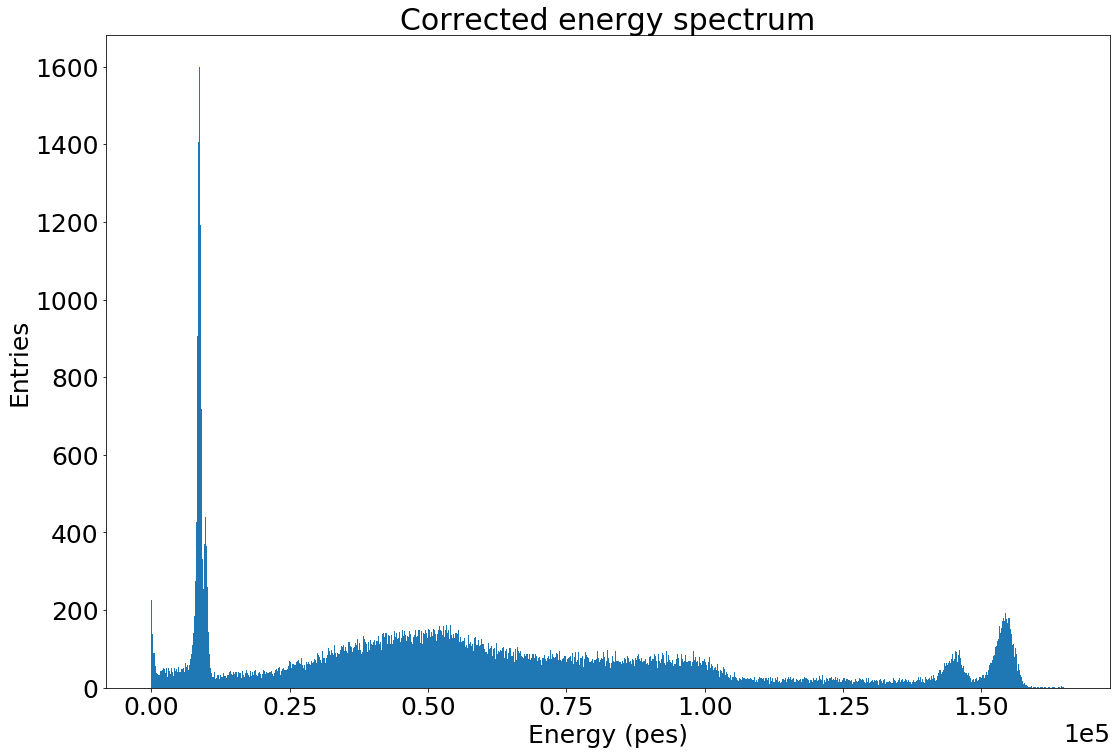

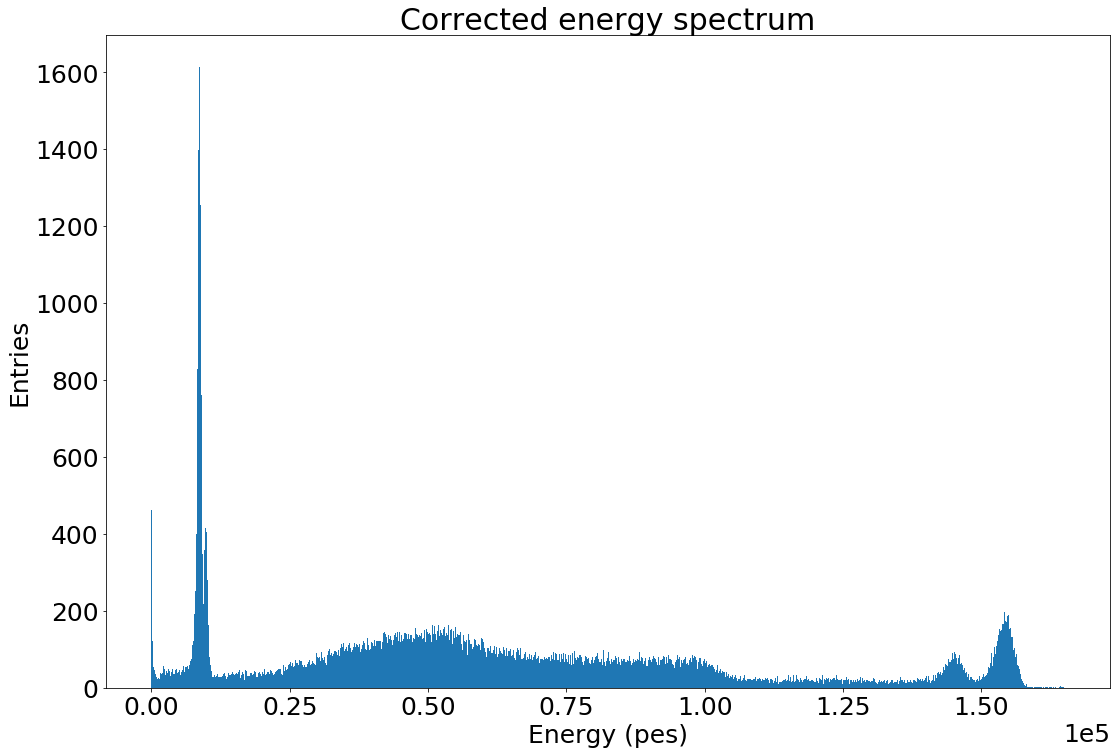

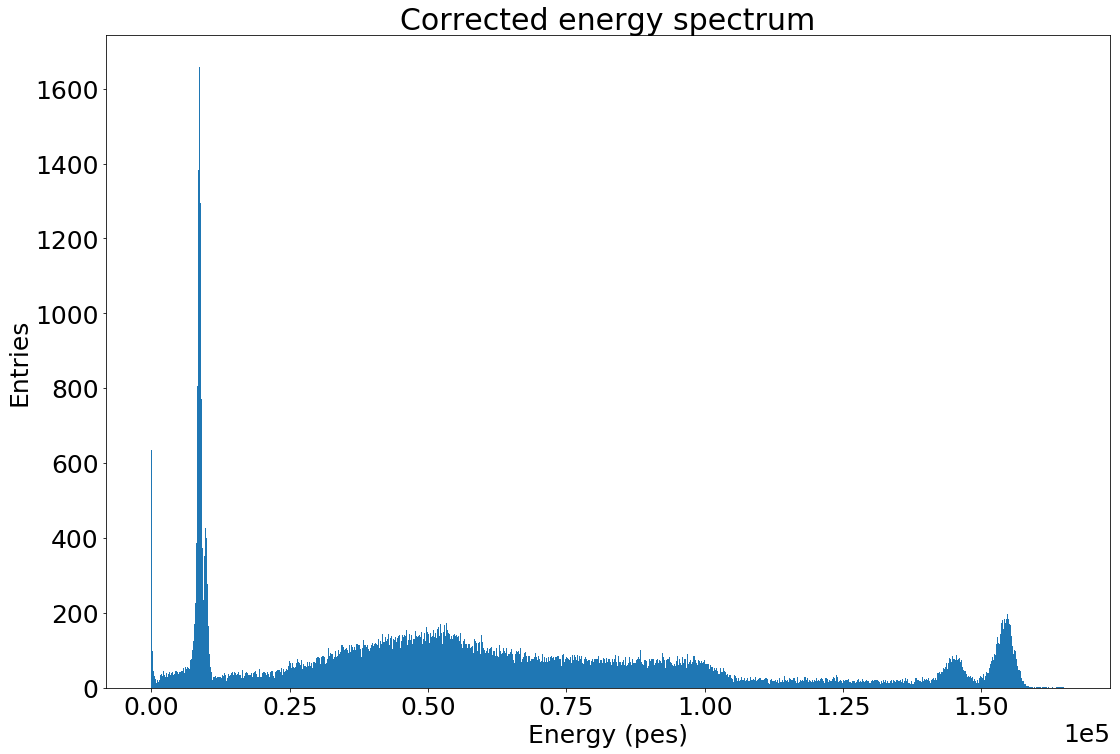

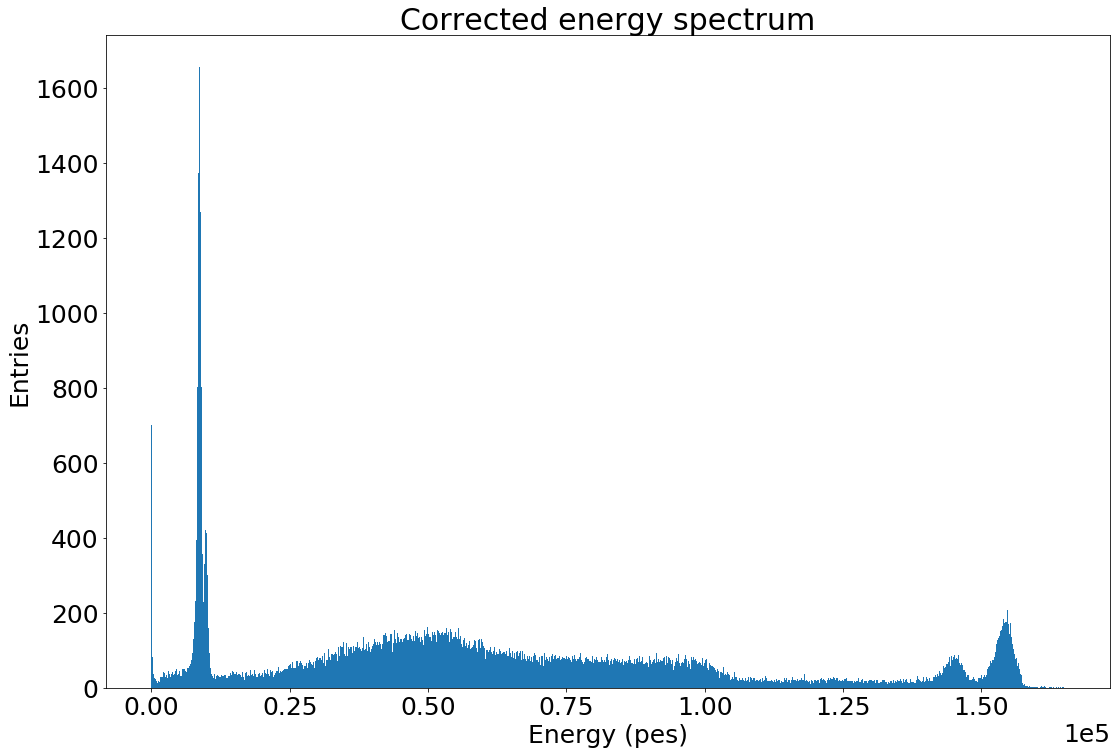

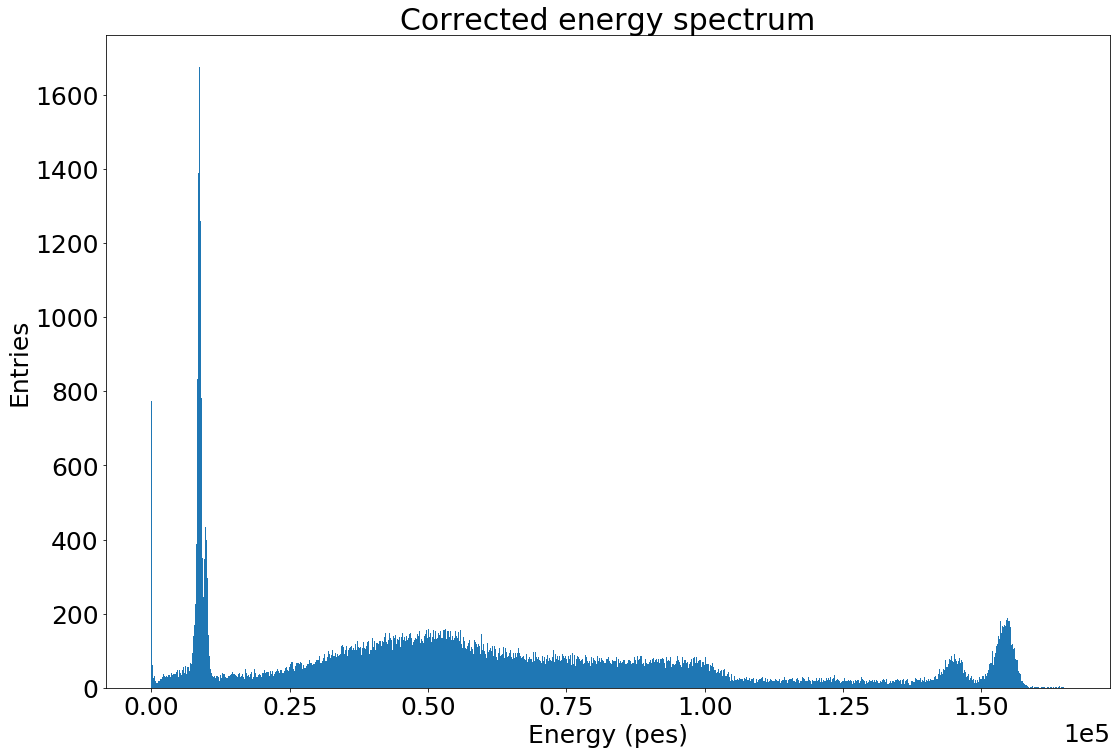

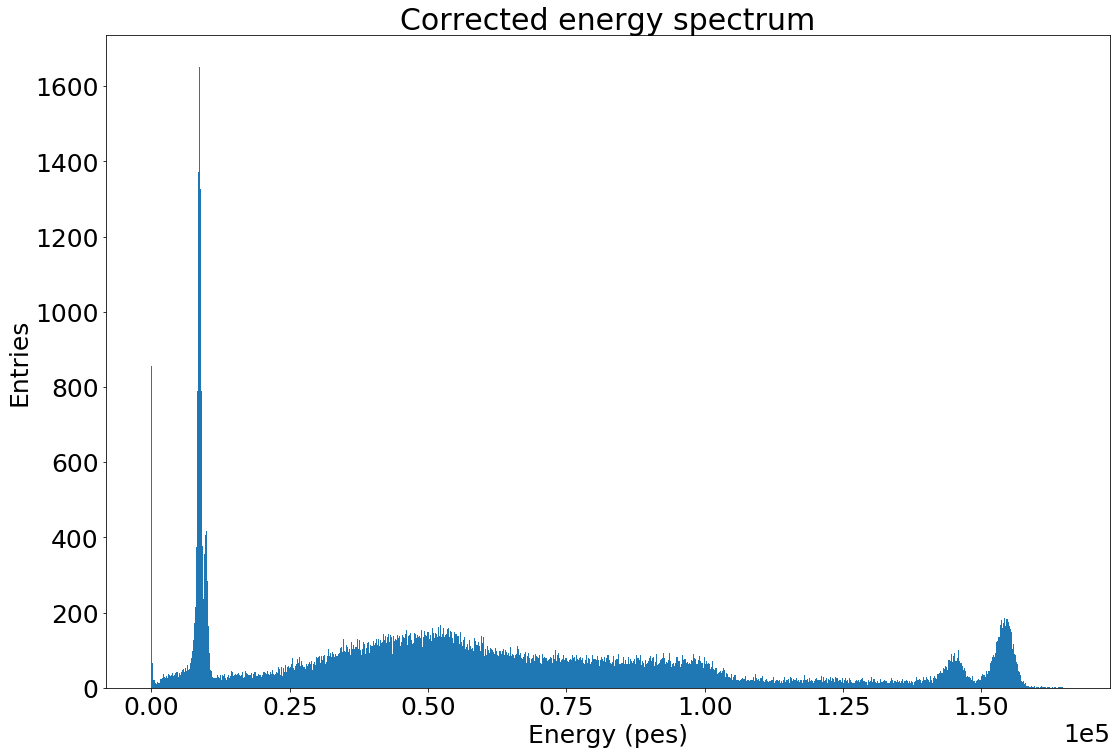

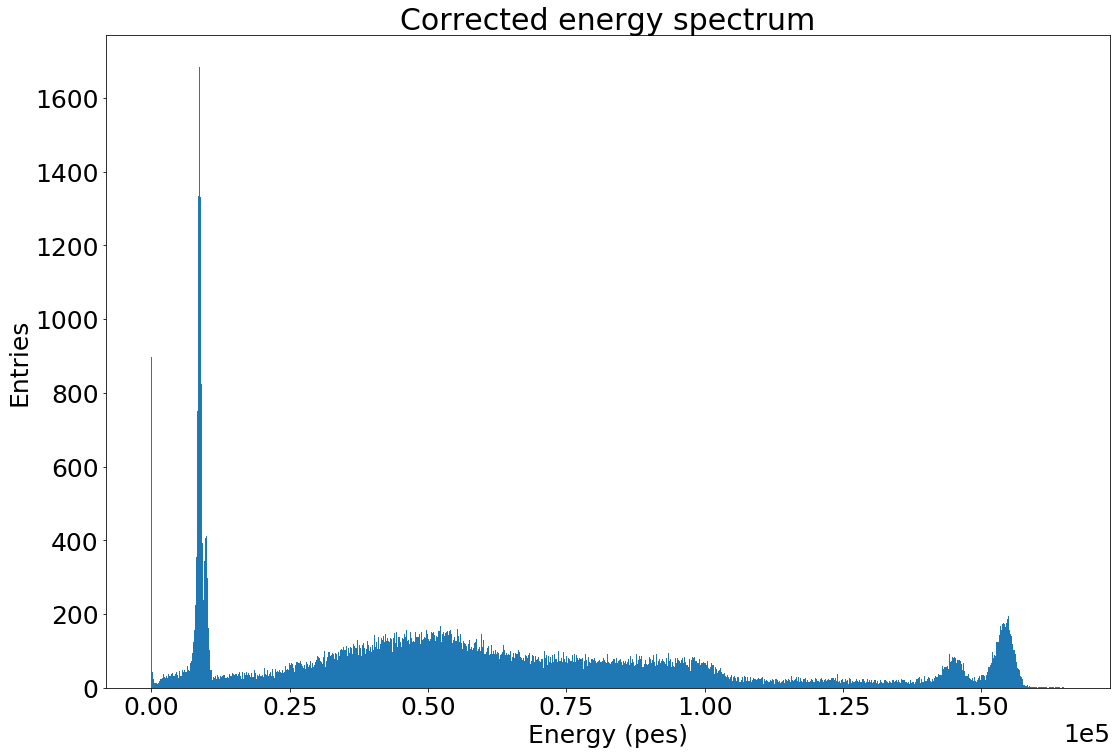

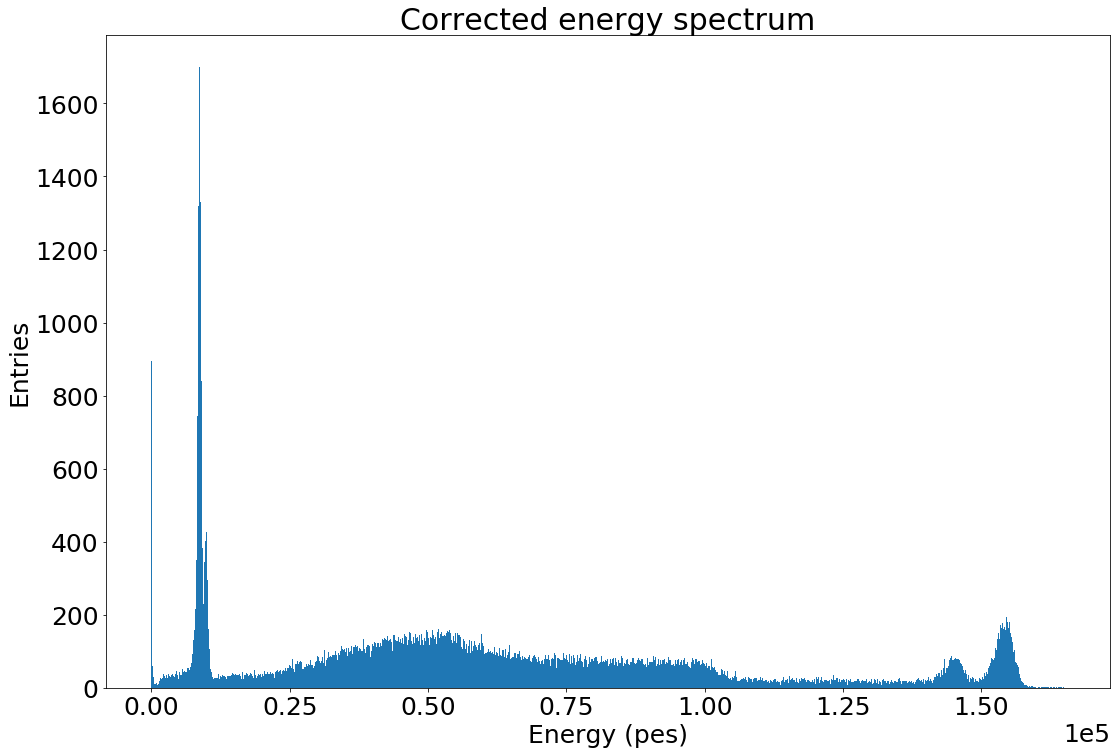

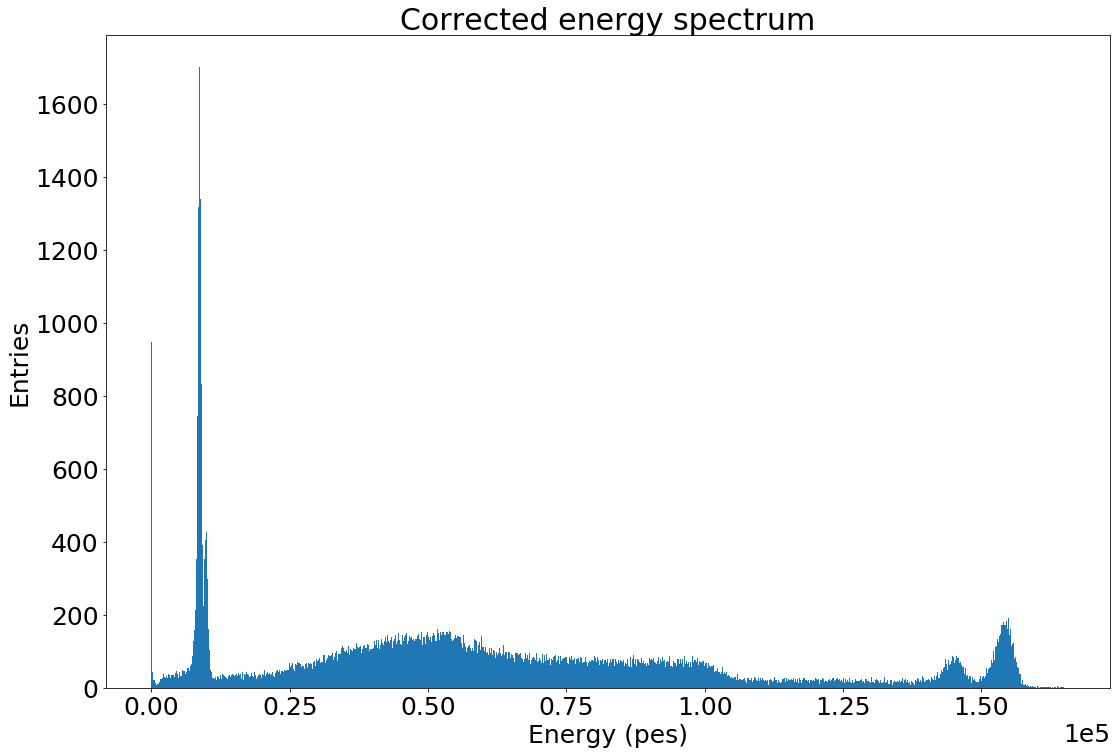

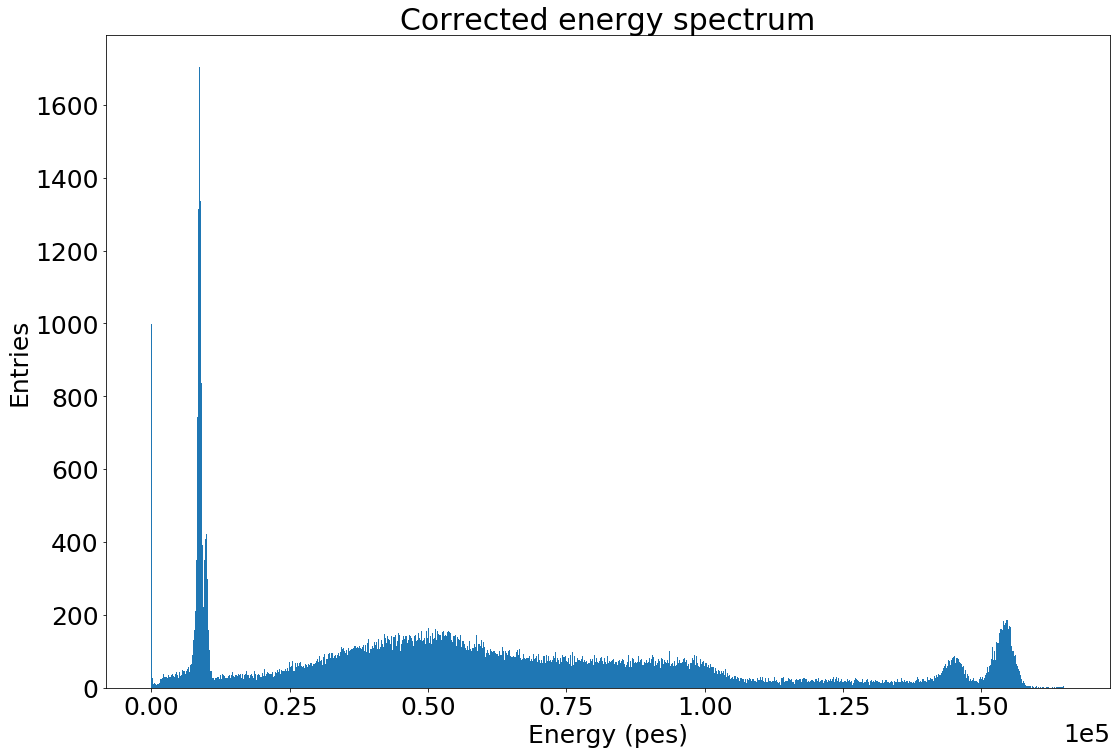

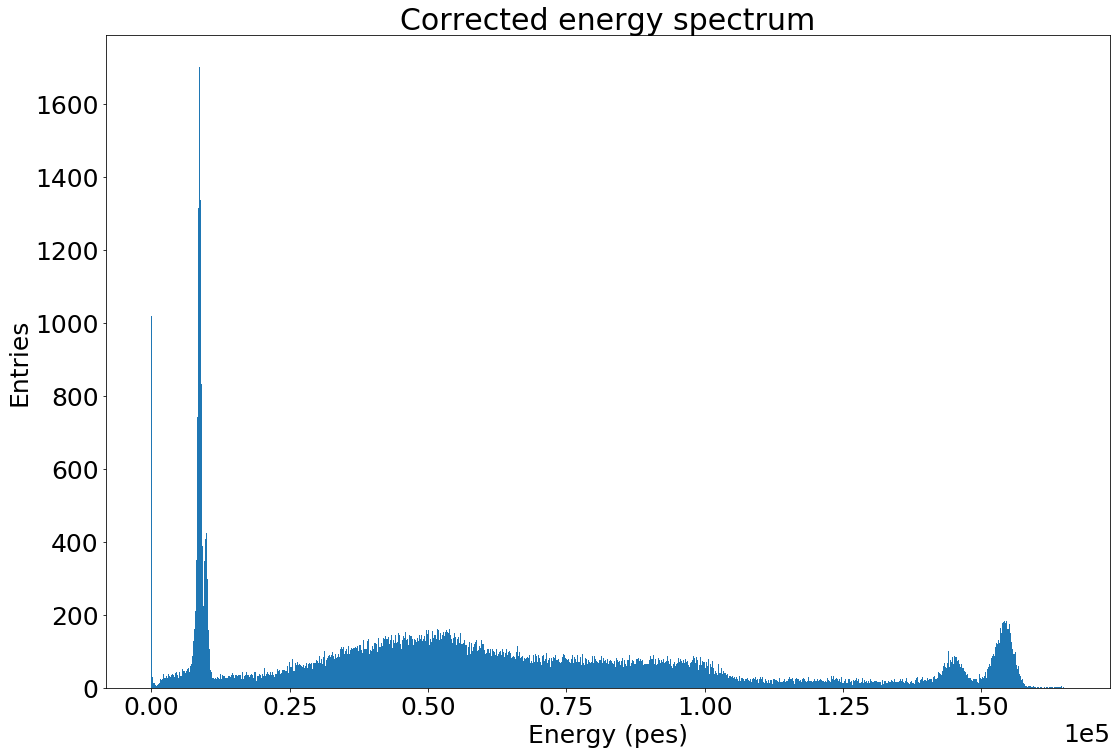

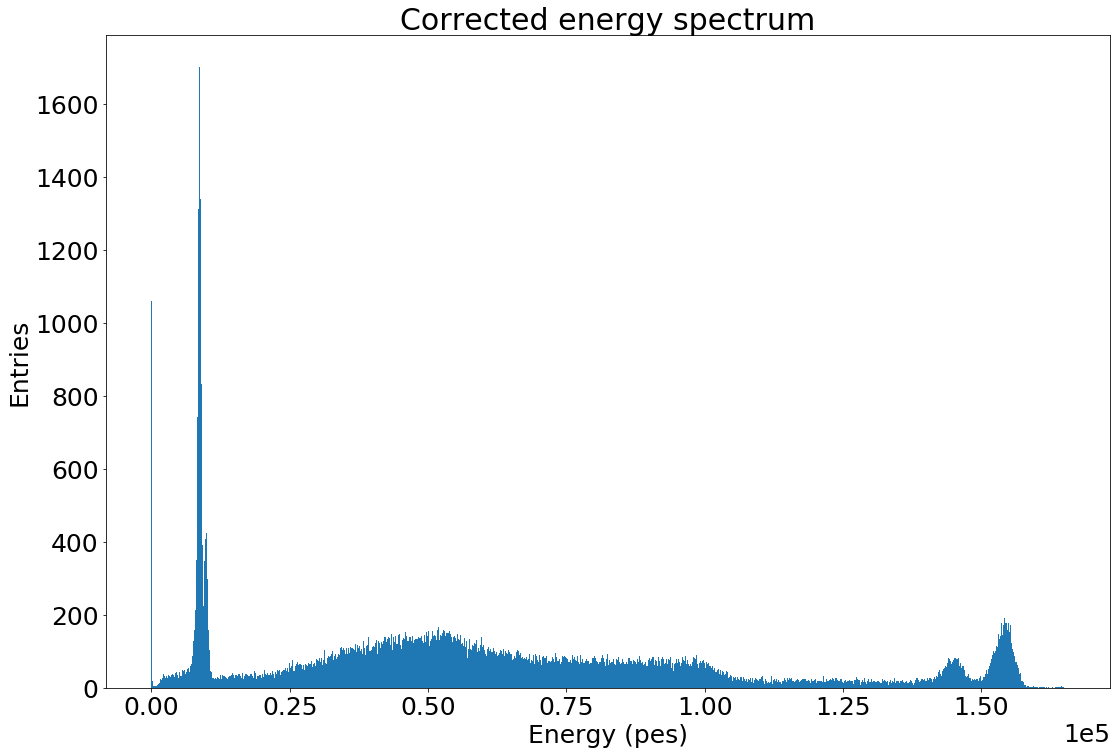

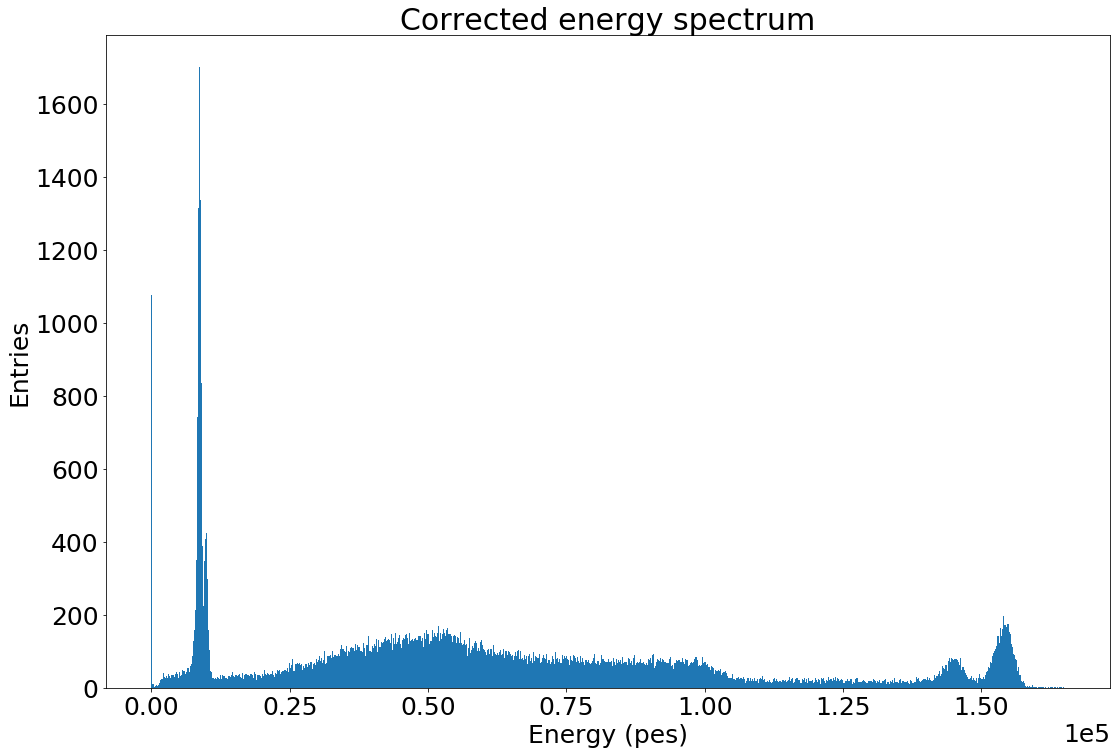

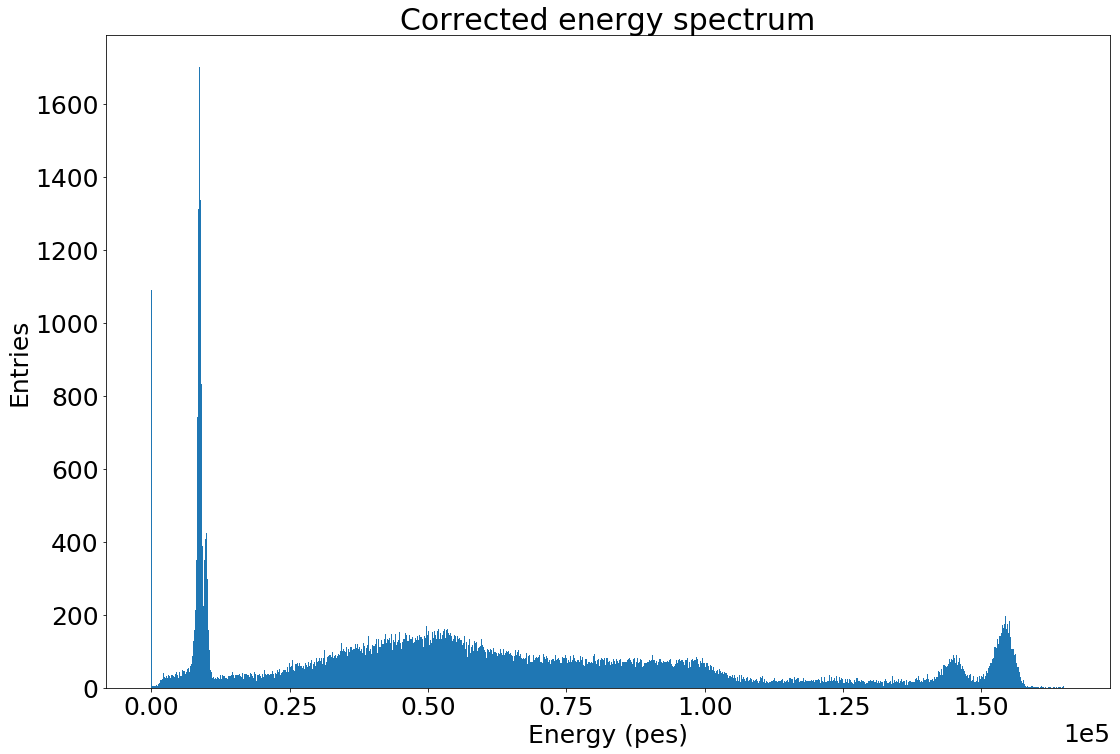

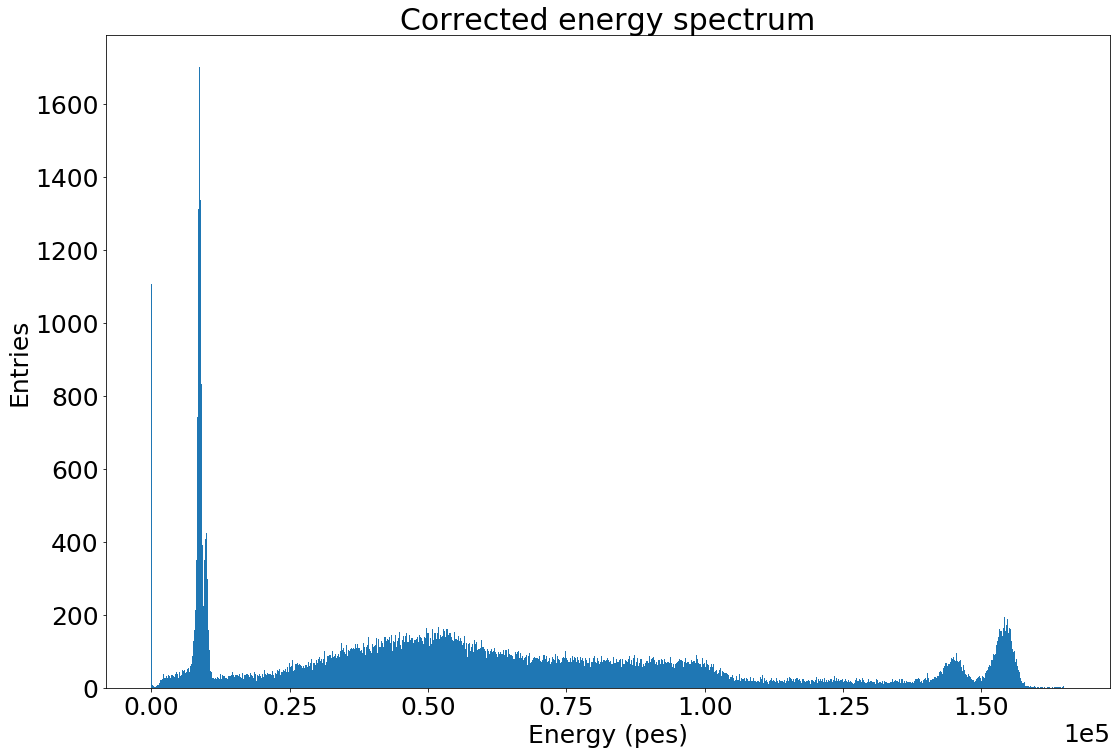

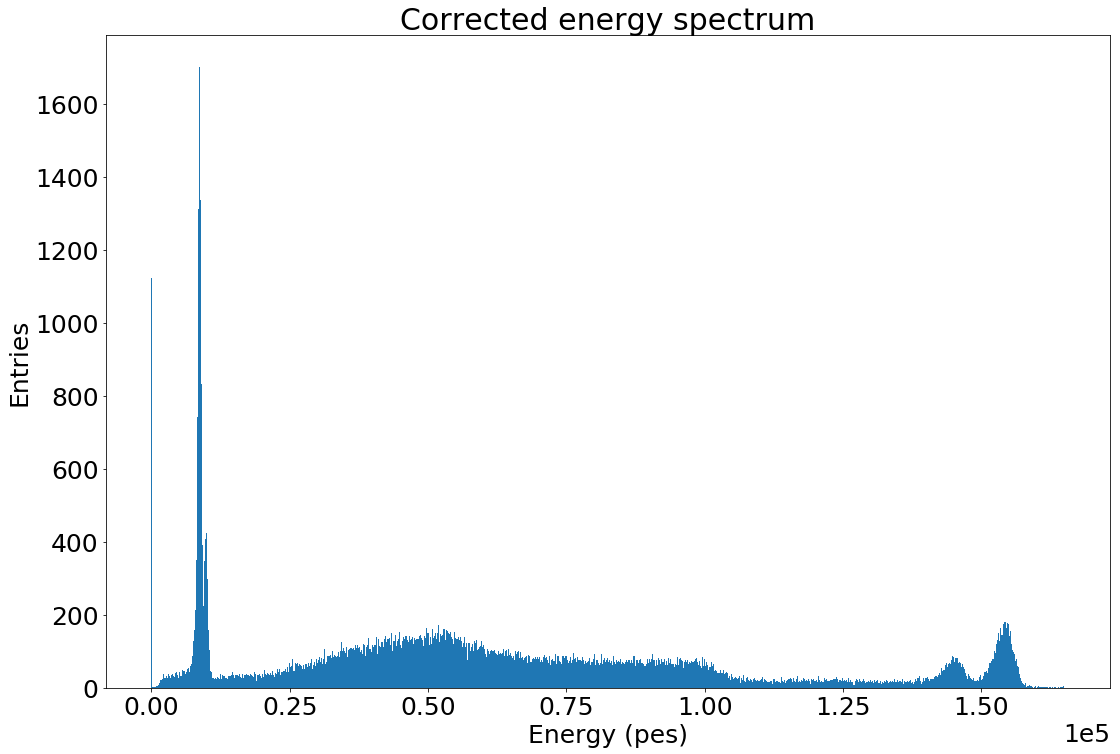

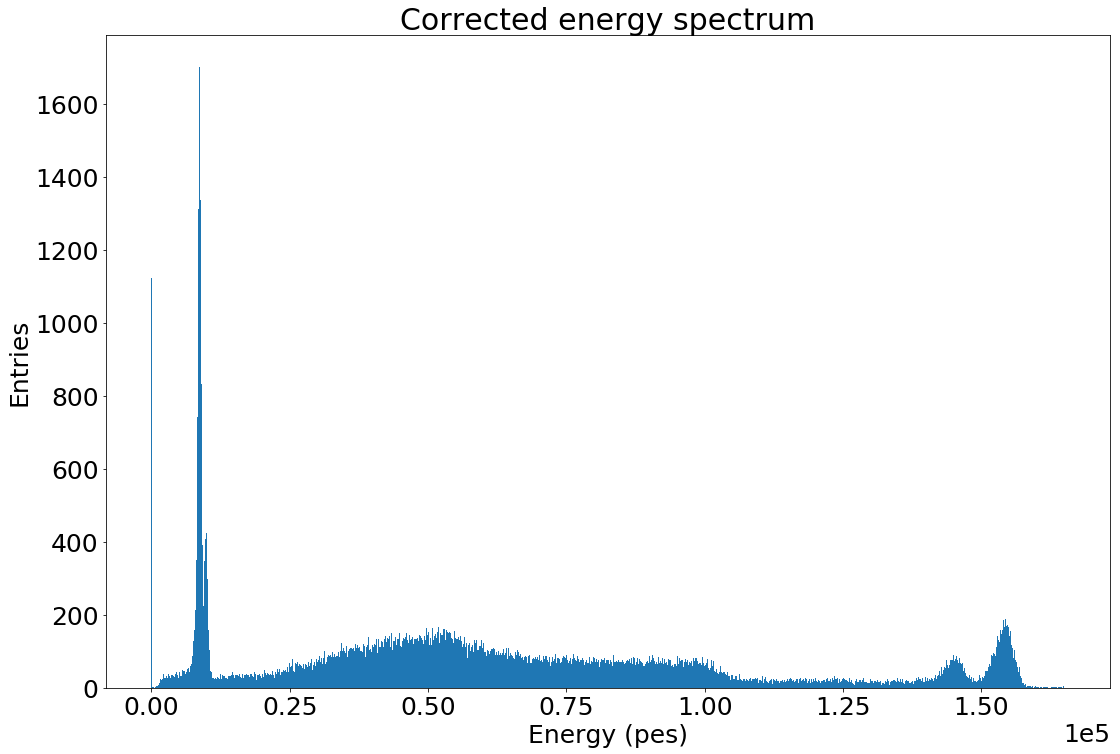

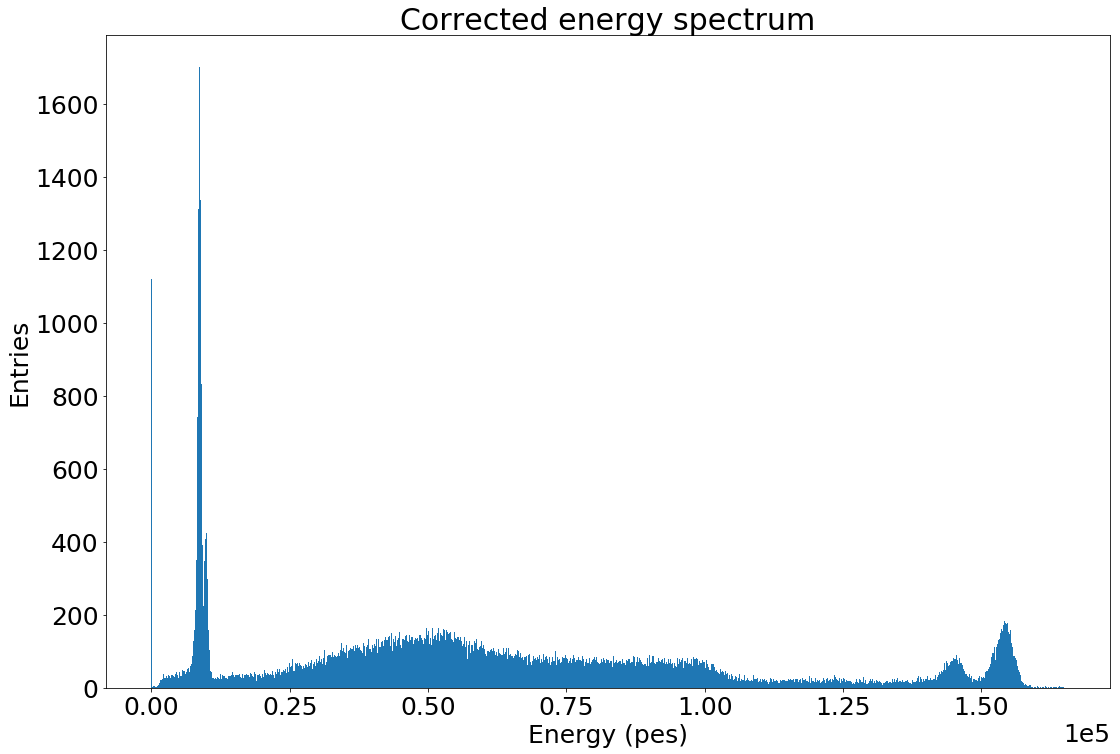

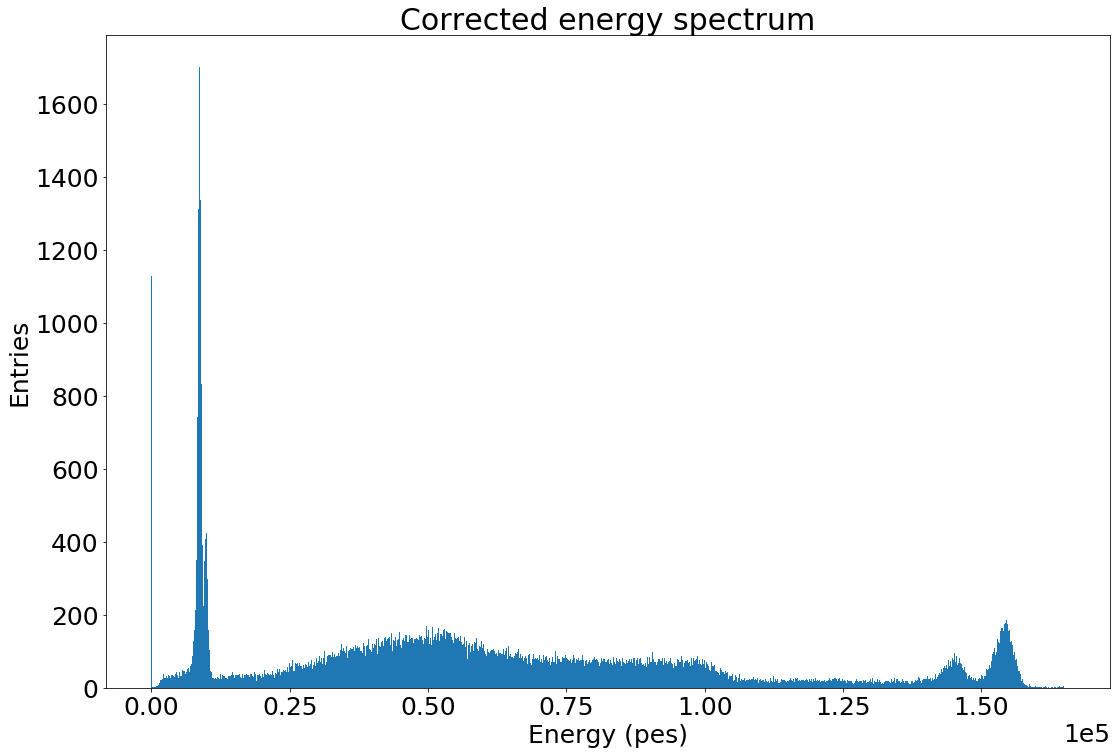

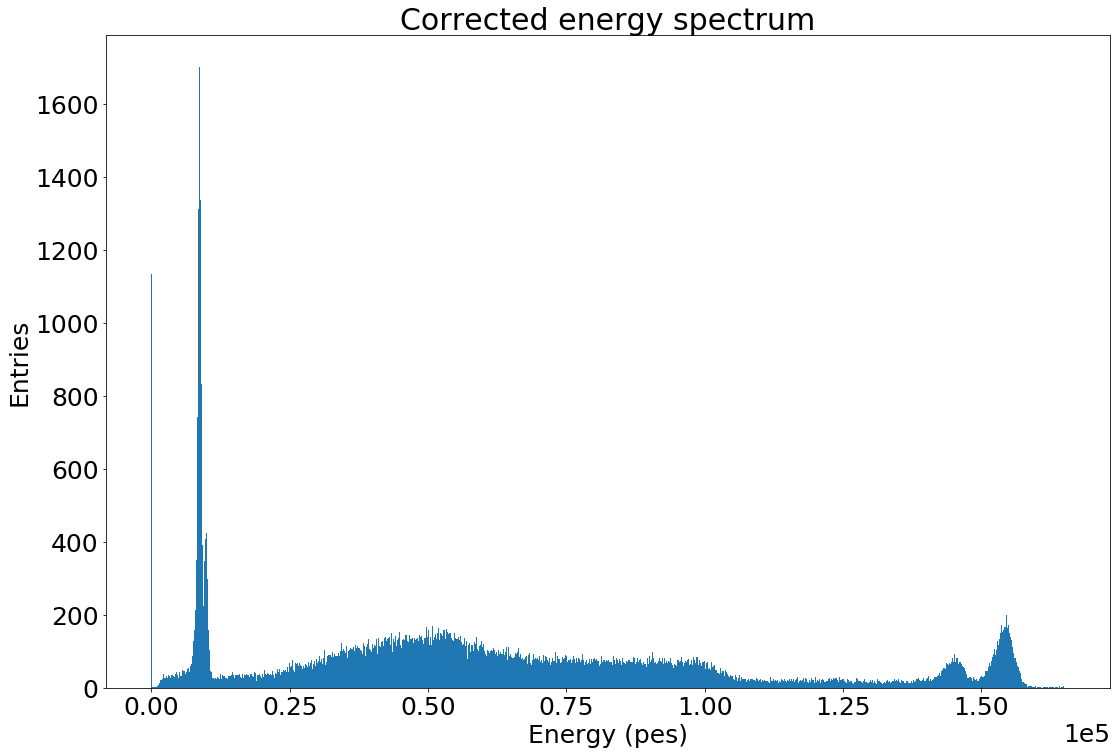

In [9]:
for n_rebin in rebin_values:
    hist(Ecorr[n_rebin], full_range_bins)
    plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
    labels("Energy (pes)", "Entries", "Corrected energy spectrum")
    save("22Na_full_corrected_spectrum_{}mm_rebin{}".format(corr_pitch, n_rebin))

# X-rays

Resolution at 29.7 keV: 7.40 +- 0.13
Resolution at 2458 keV: 0.814 +- 0.015
Chi2                  : 1.02104934134
Resolution at 29.7 keV: 7.42 +- 0.14
Resolution at 2458 keV: 0.815 +- 0.015
Chi2                  : 1.03076948928
Resolution at 29.7 keV: 7.30 +- 0.12
Resolution at 2458 keV: 0.803 +- 0.014
Chi2                  : 0.955347283605
Resolution at 29.7 keV: 7.41 +- 0.14
Resolution at 2458 keV: 0.815 +- 0.015
Chi2                  : 1.153525227
Resolution at 29.7 keV: 7.25 +- 0.12
Resolution at 2458 keV: 0.797 +- 0.014
Chi2                  : 0.948083106529
Resolution at 29.7 keV: 7.311 +- 0.096
Resolution at 2458 keV: 0.804 +- 0.011
Chi2                  : 0.577255203837
Resolution at 29.7 keV: 7.27 +- 0.13
Resolution at 2458 keV: 0.799 +- 0.014
Chi2                  : 1.04189392001
Resolution at 29.7 keV: 7.28 +- 0.14
Resolution at 2458 keV: 0.800 +- 0.015
Chi2                  : 1.23148387912
Resolution at 29.7 keV: 7.29 +- 0.12
Resolution at 2458 keV: 0.801 +- 0.013
Chi2     

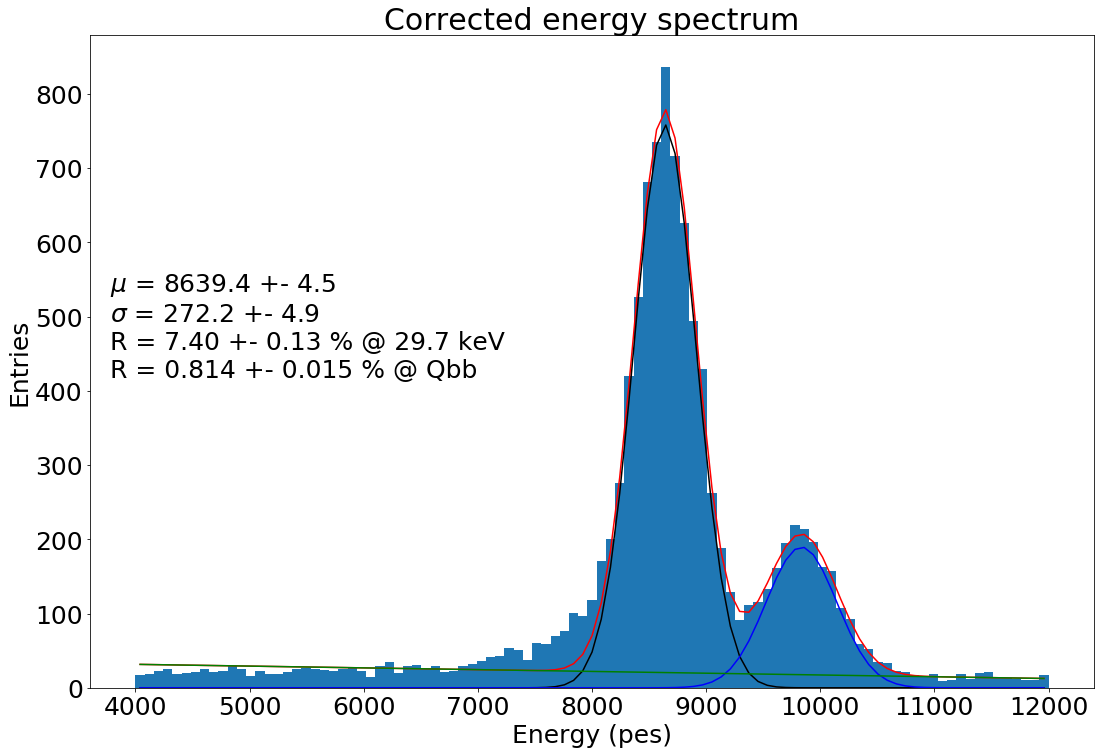

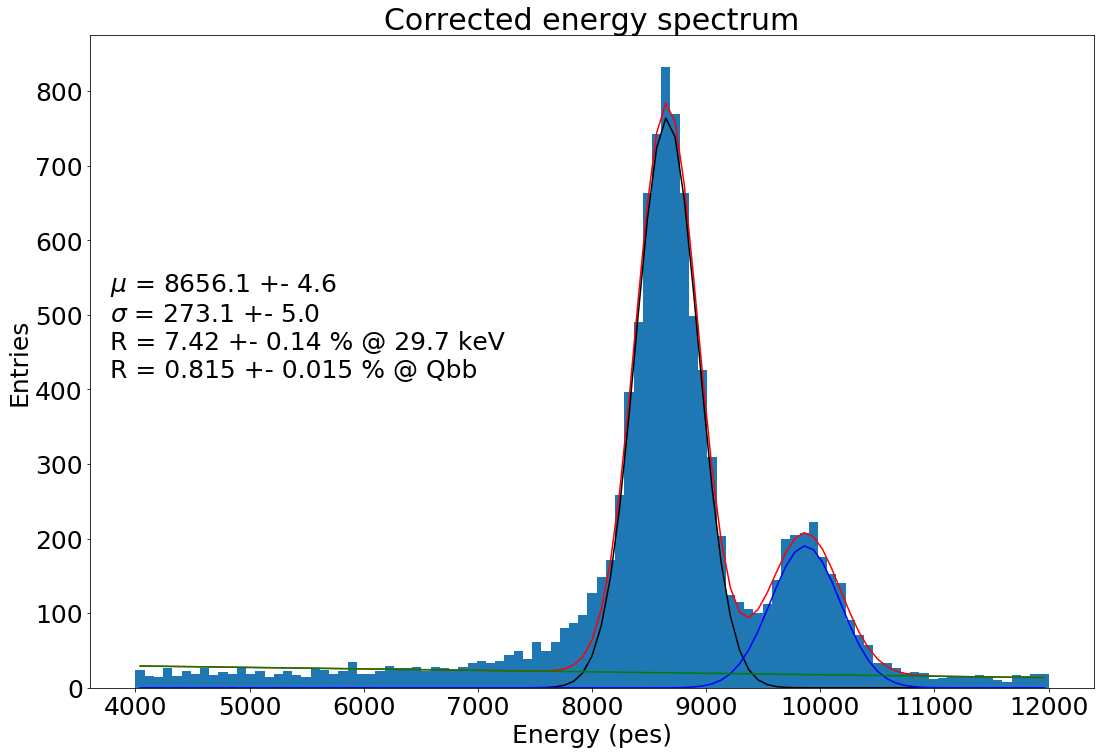

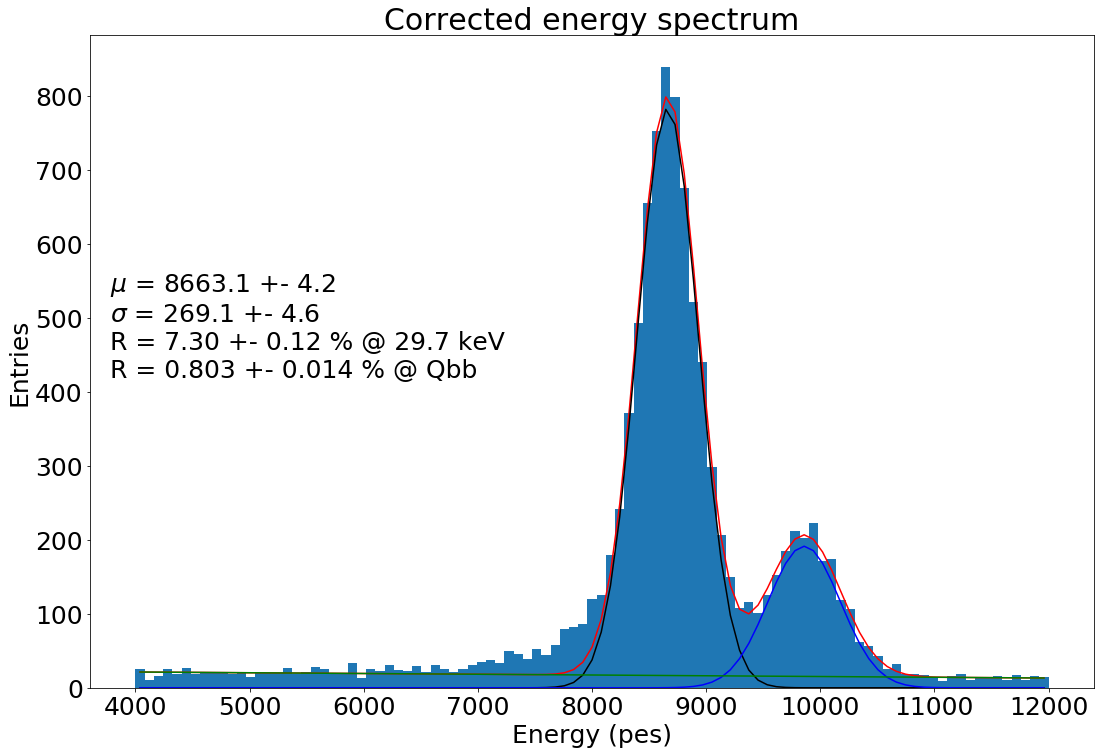

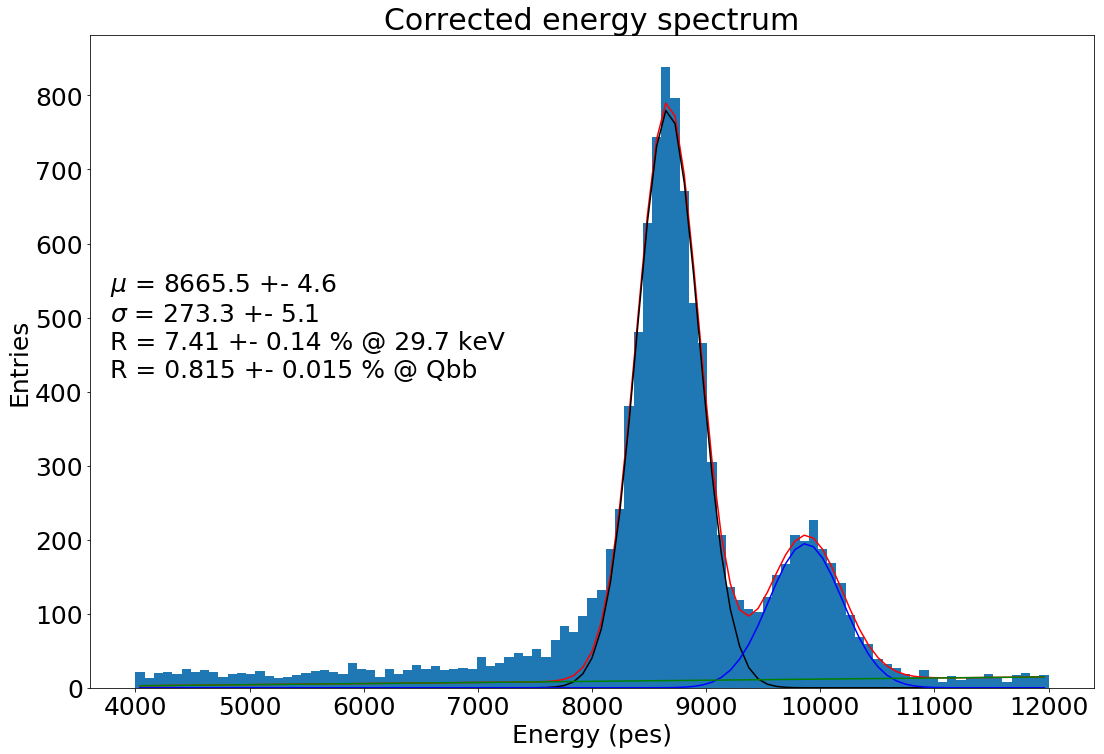

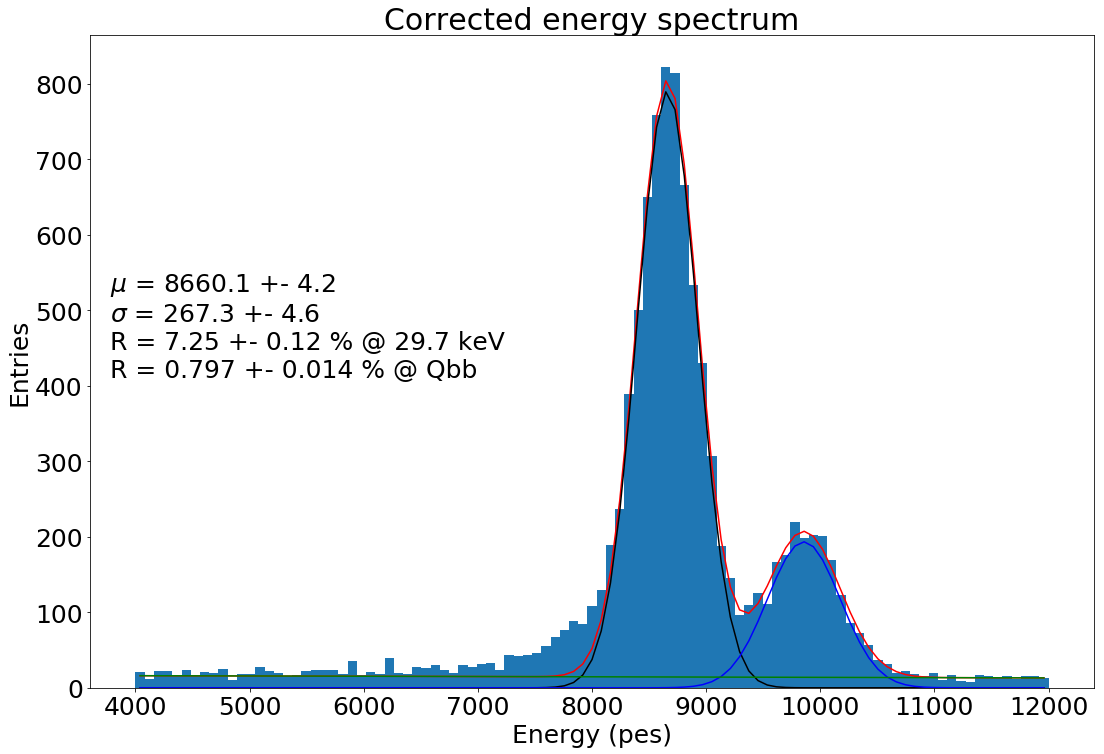

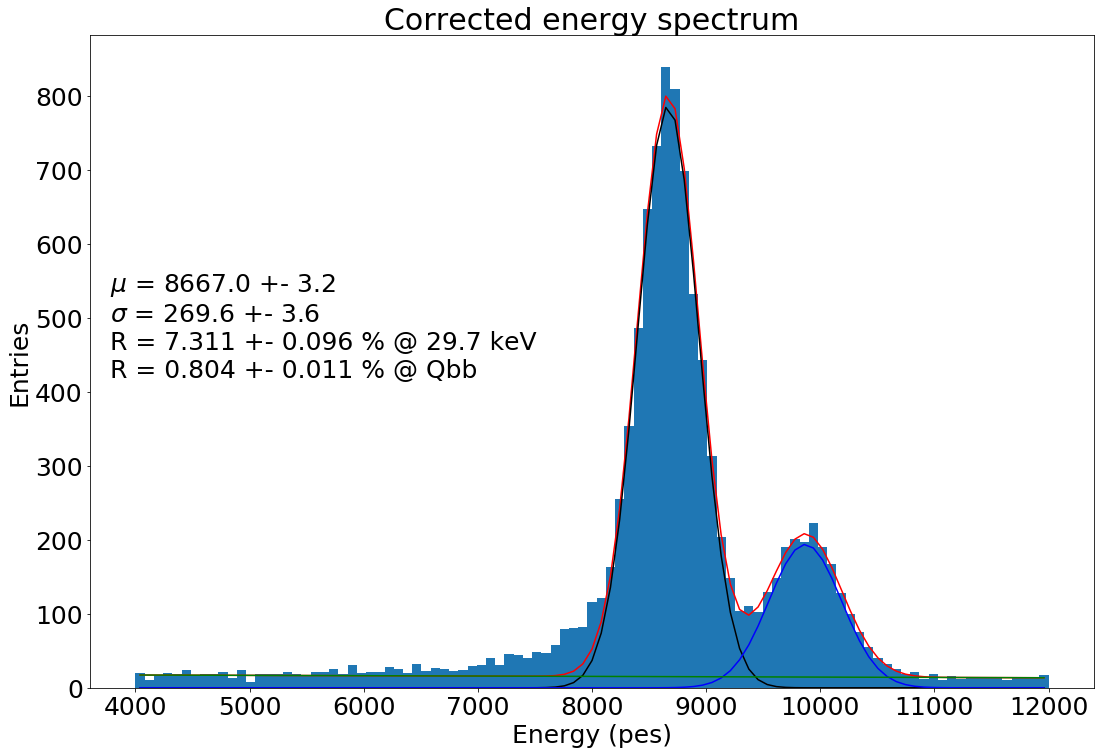

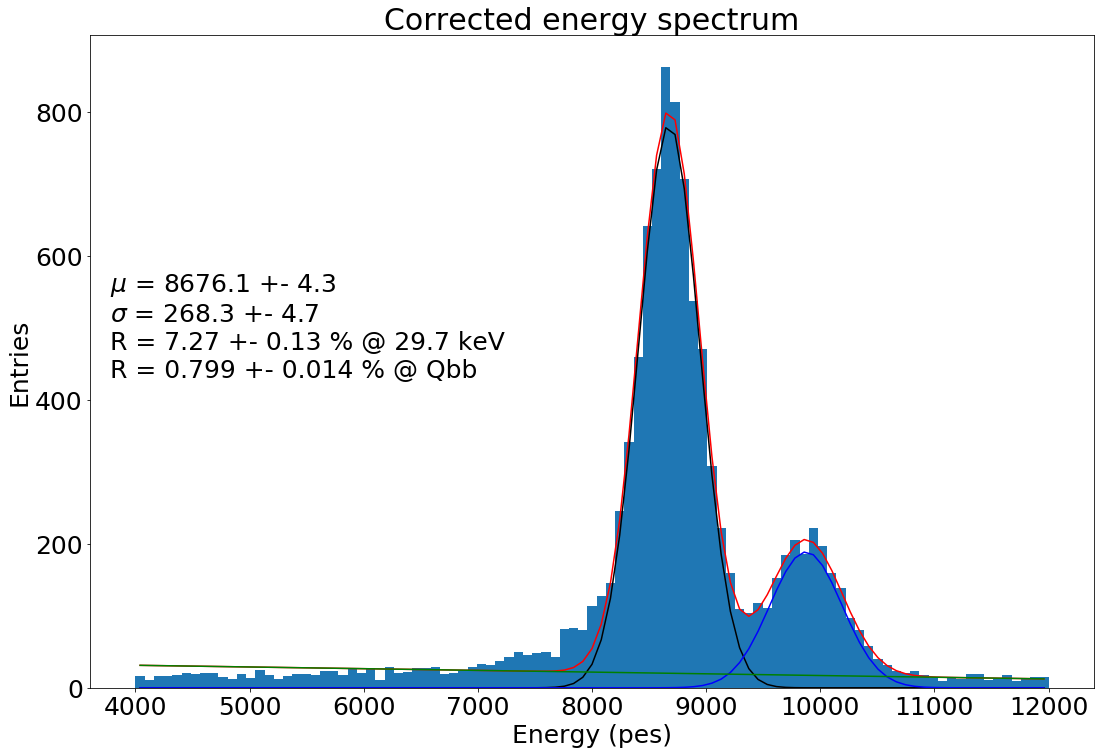

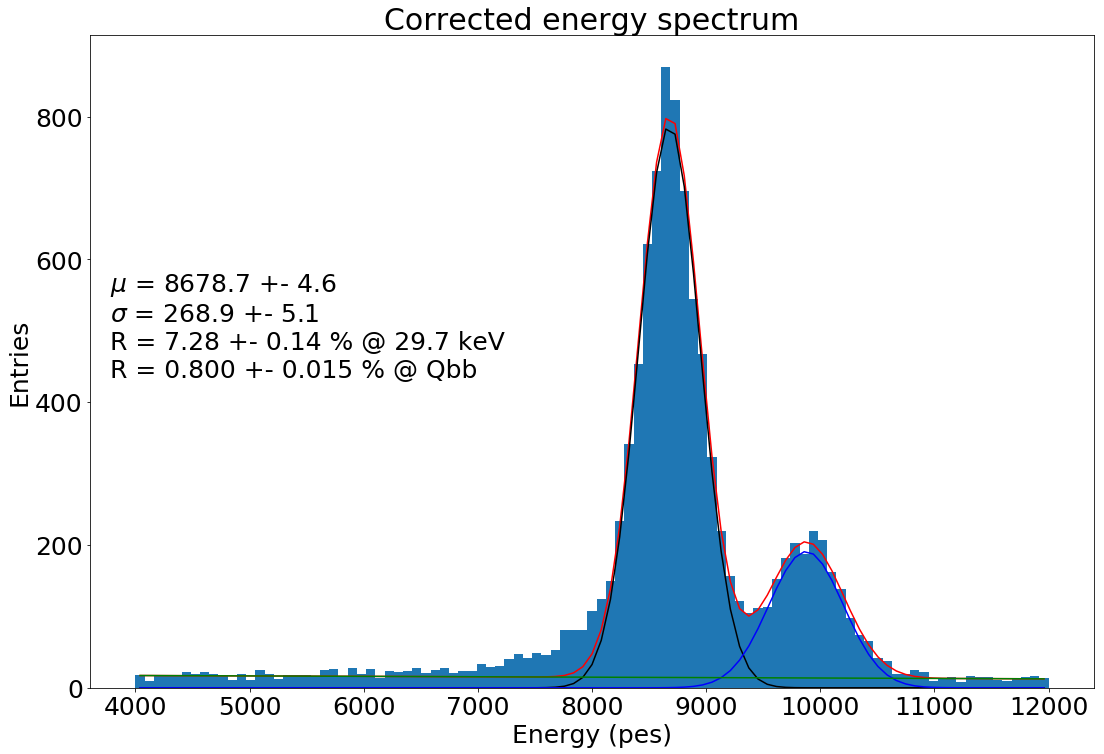

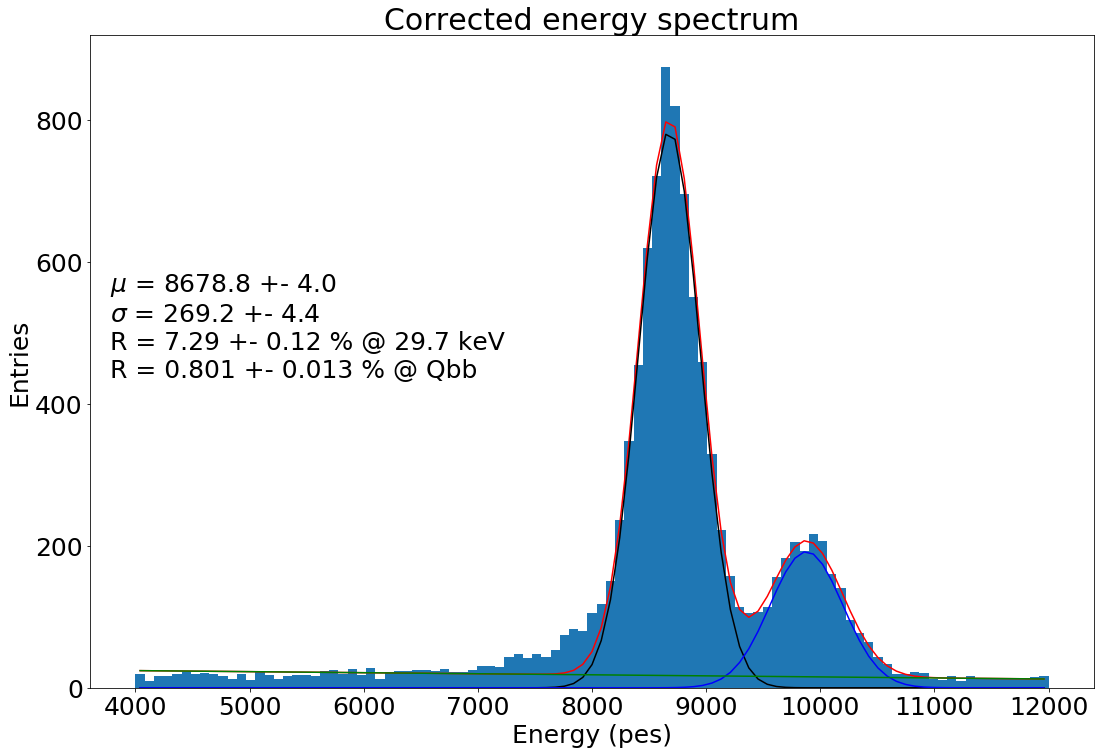

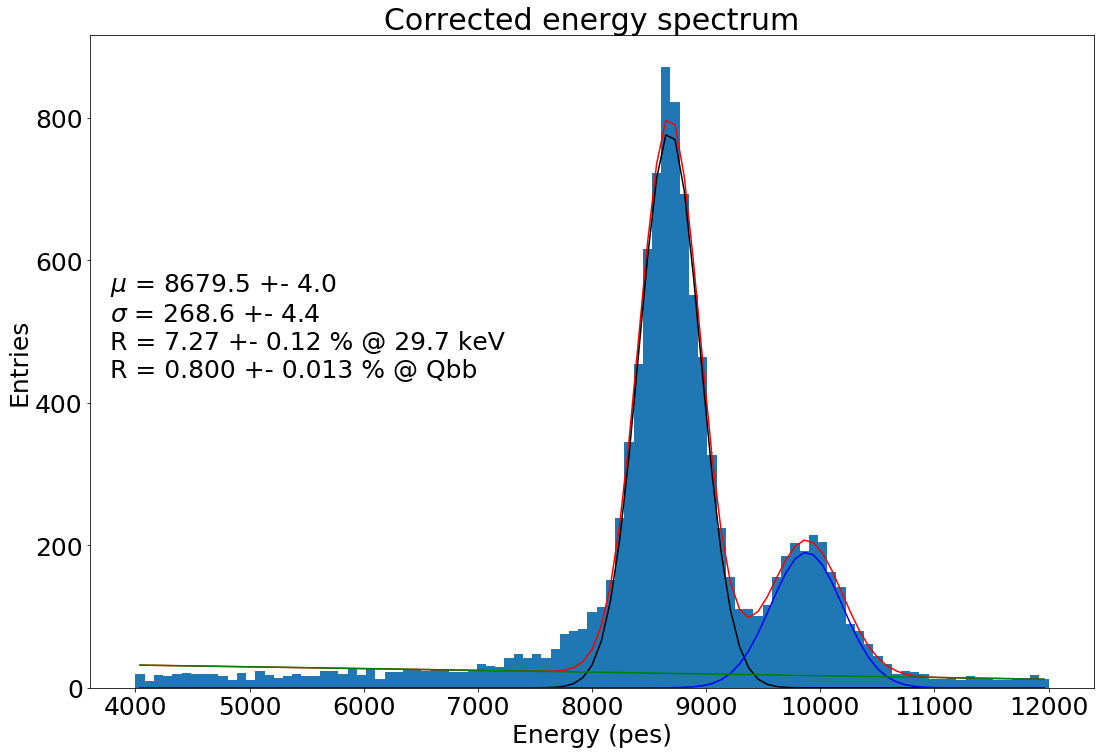

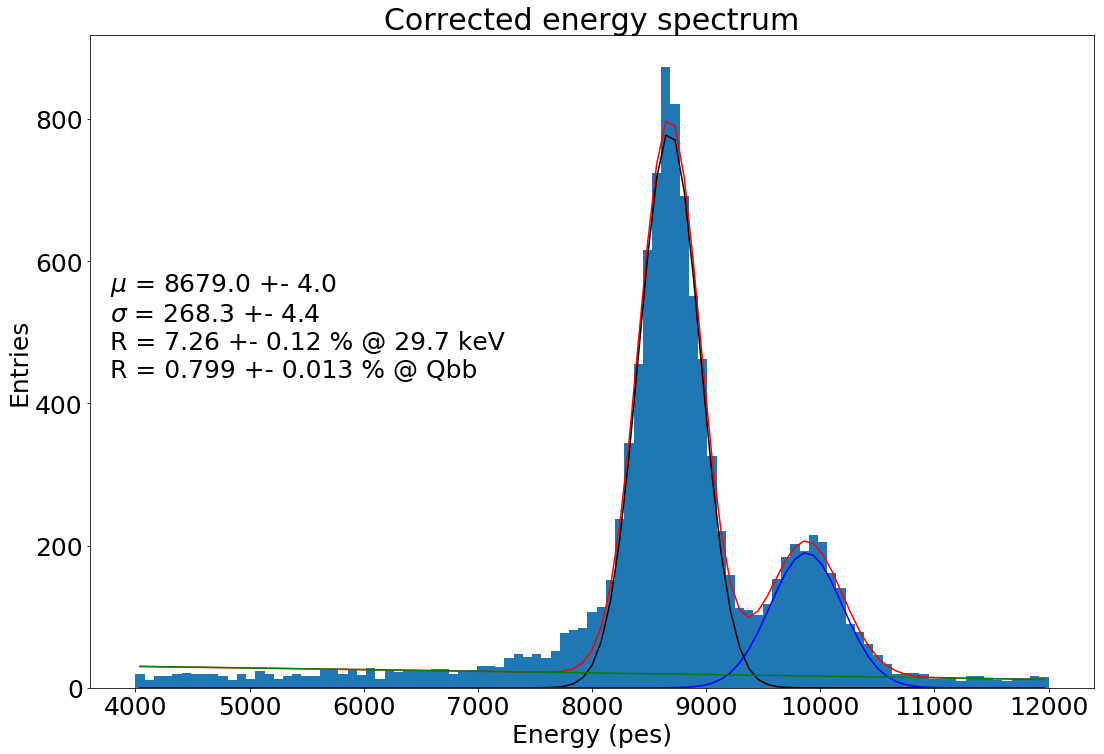

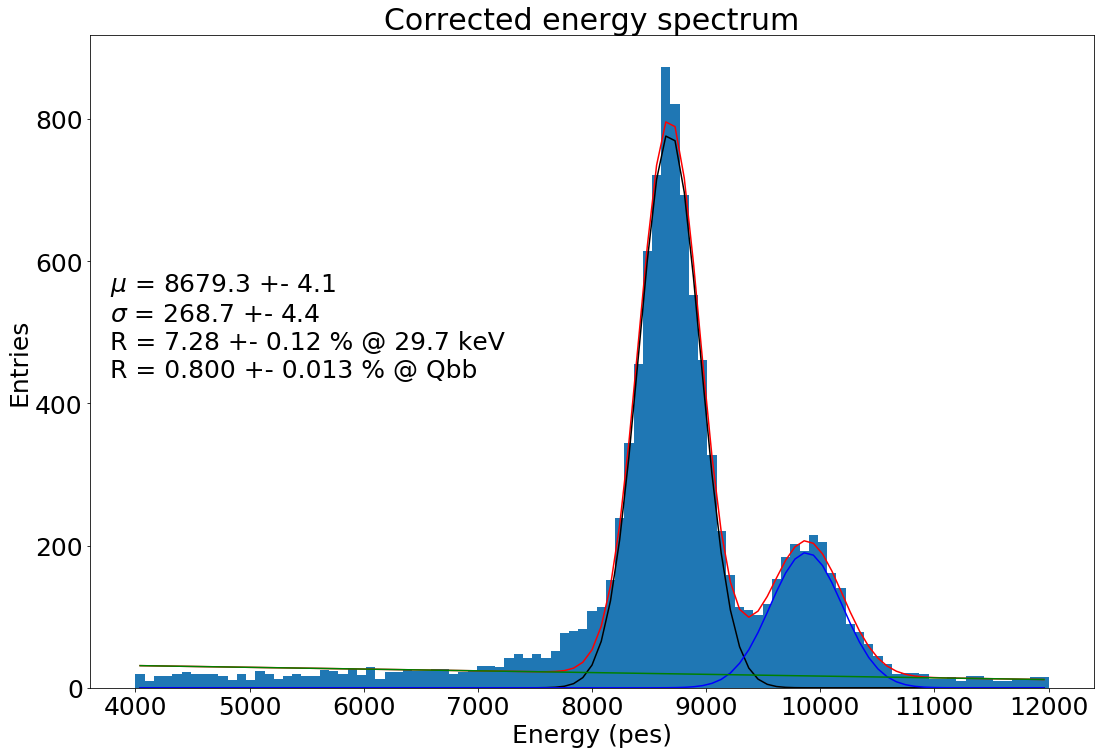

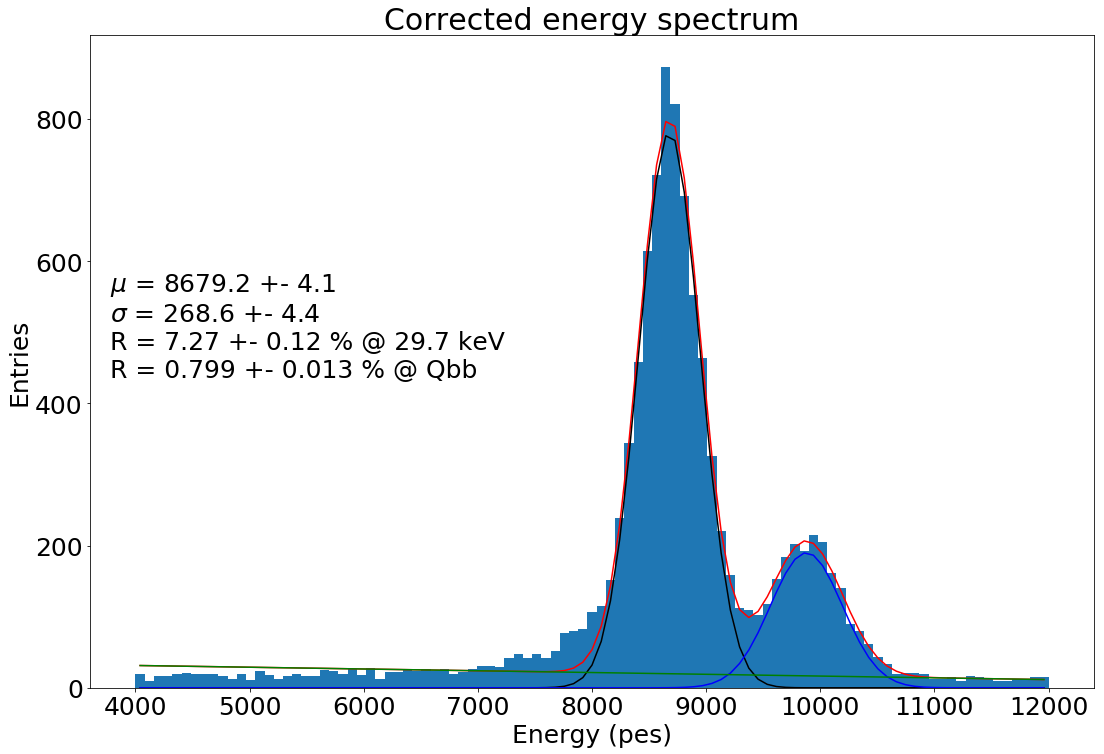

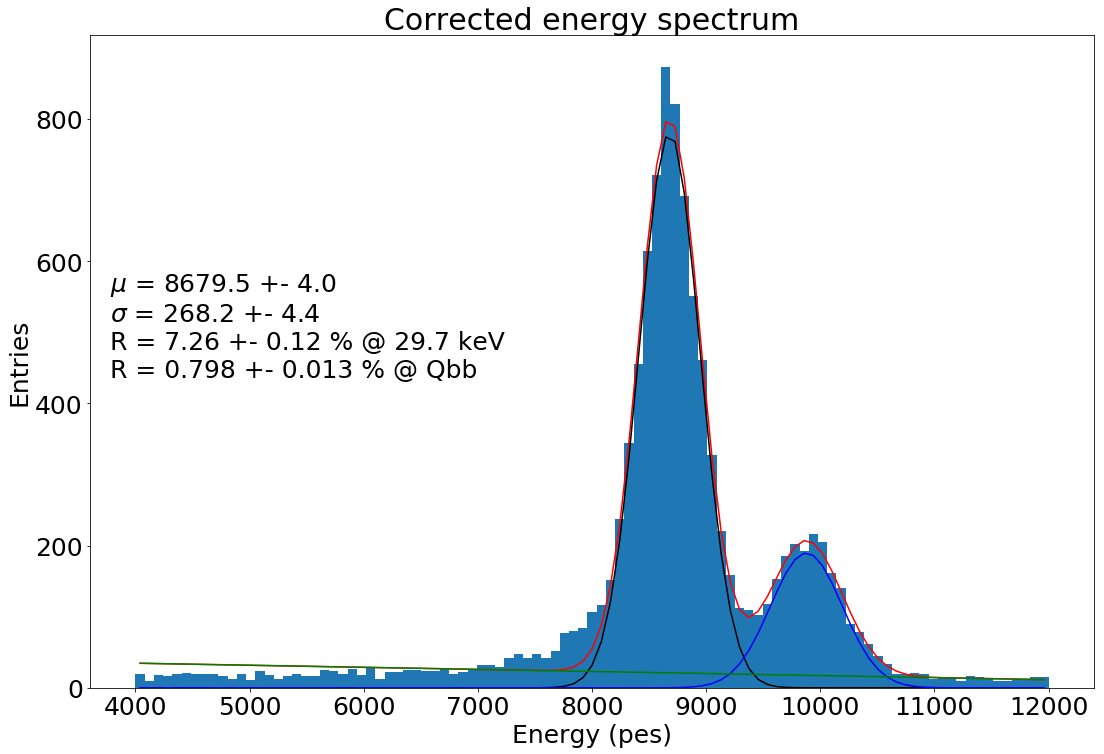

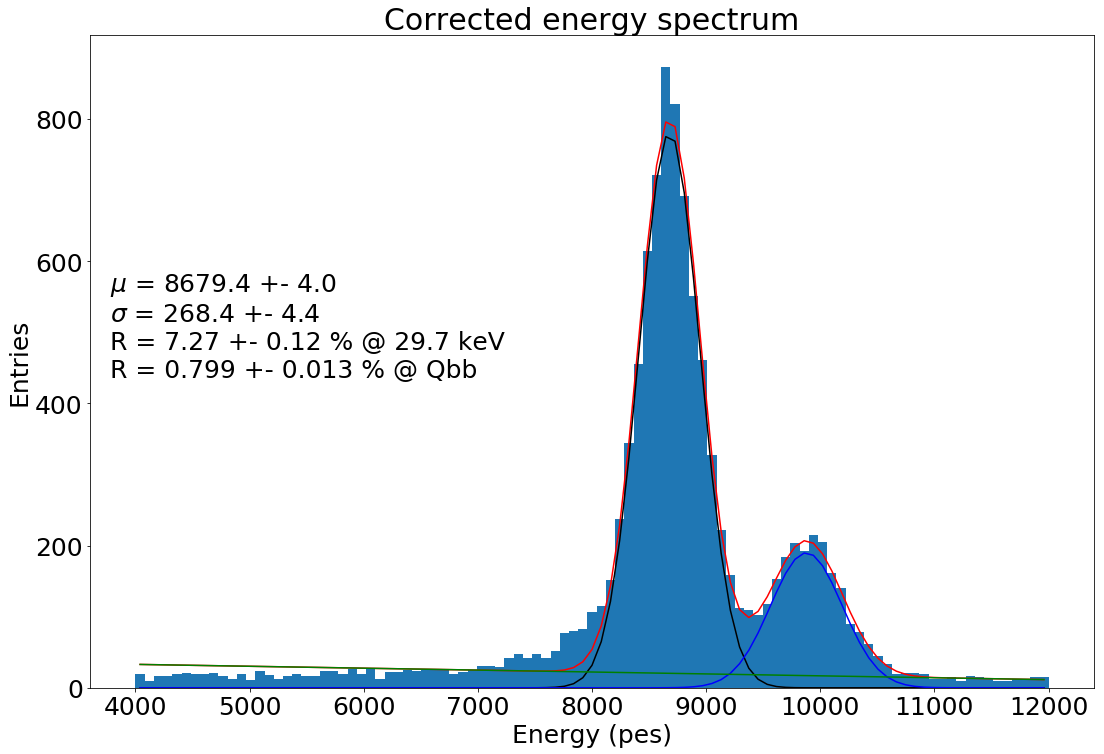

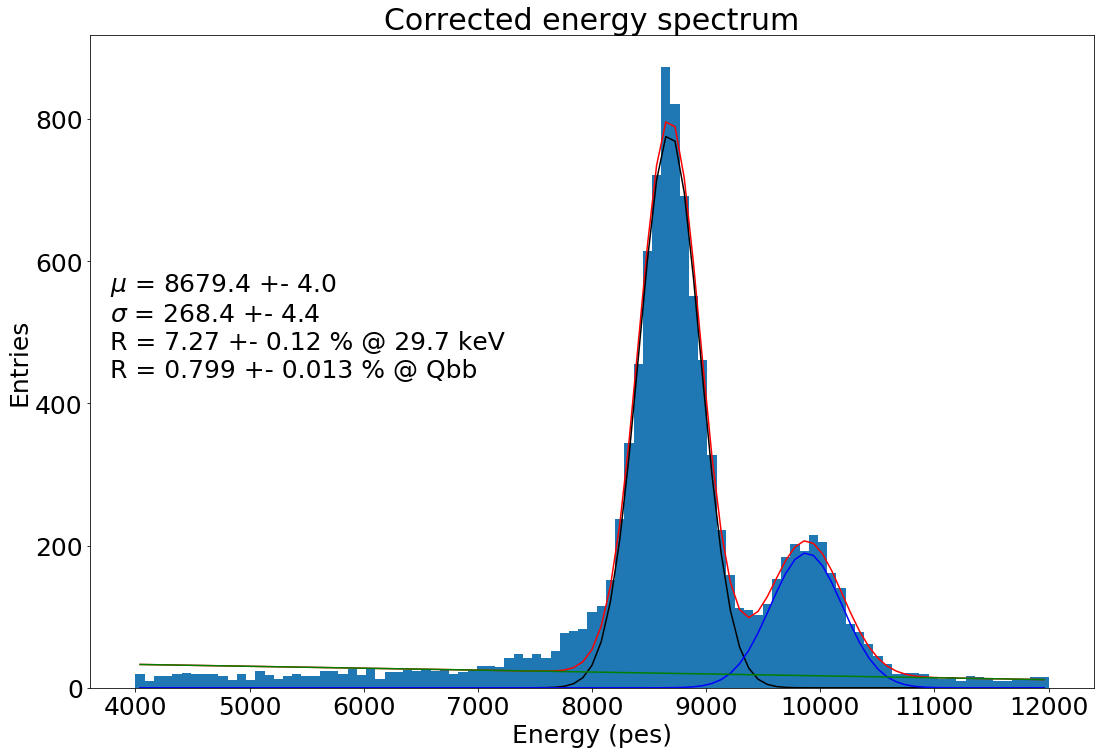

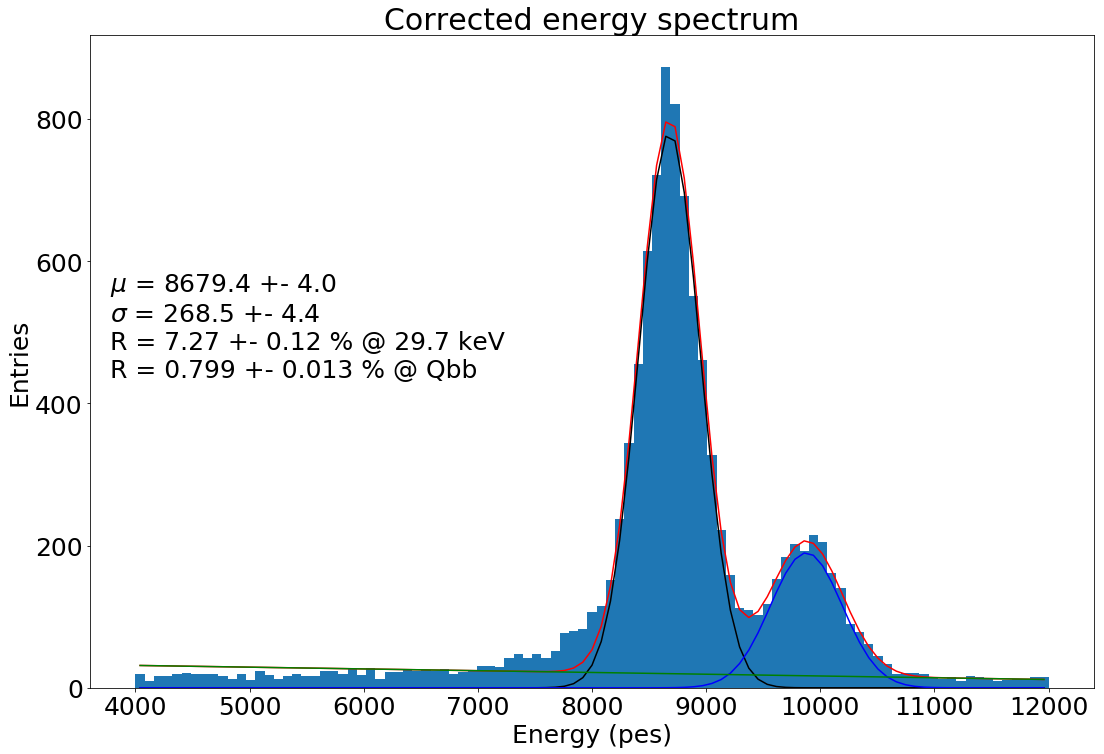

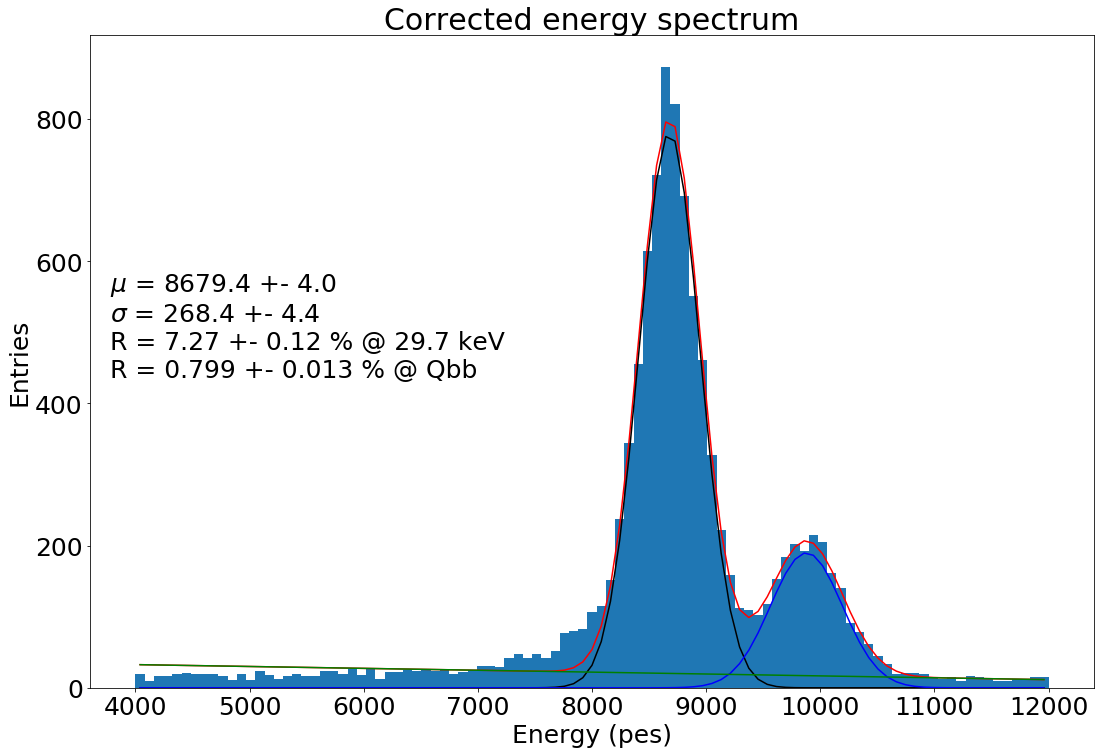

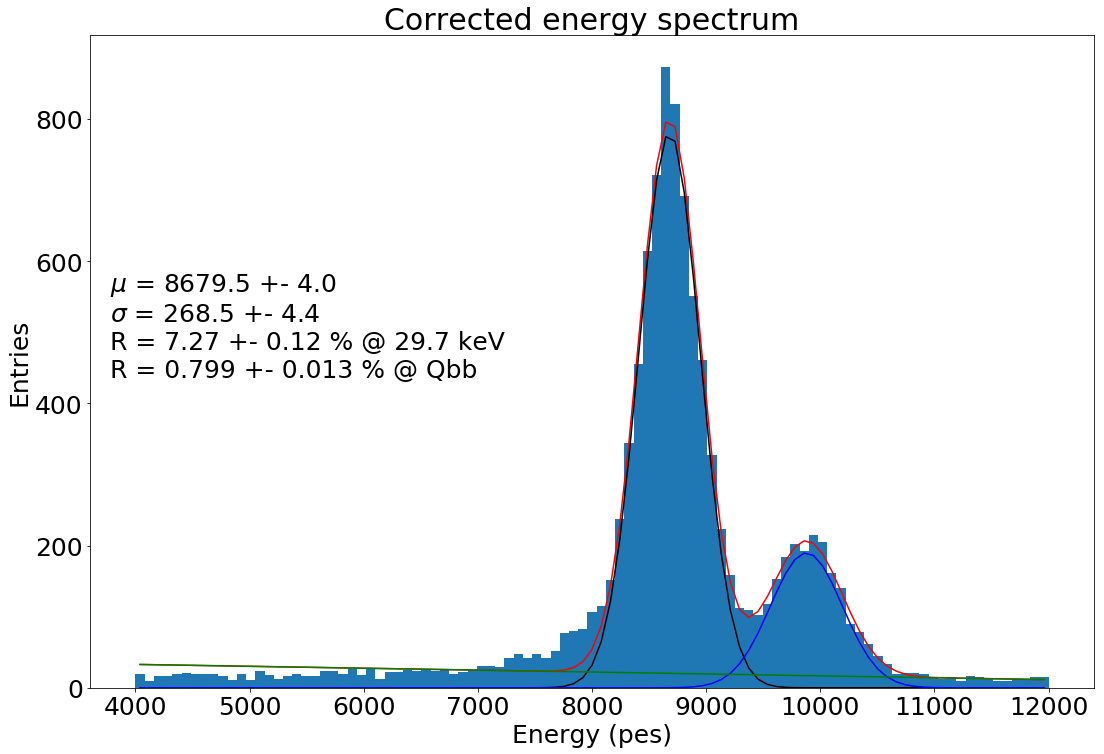

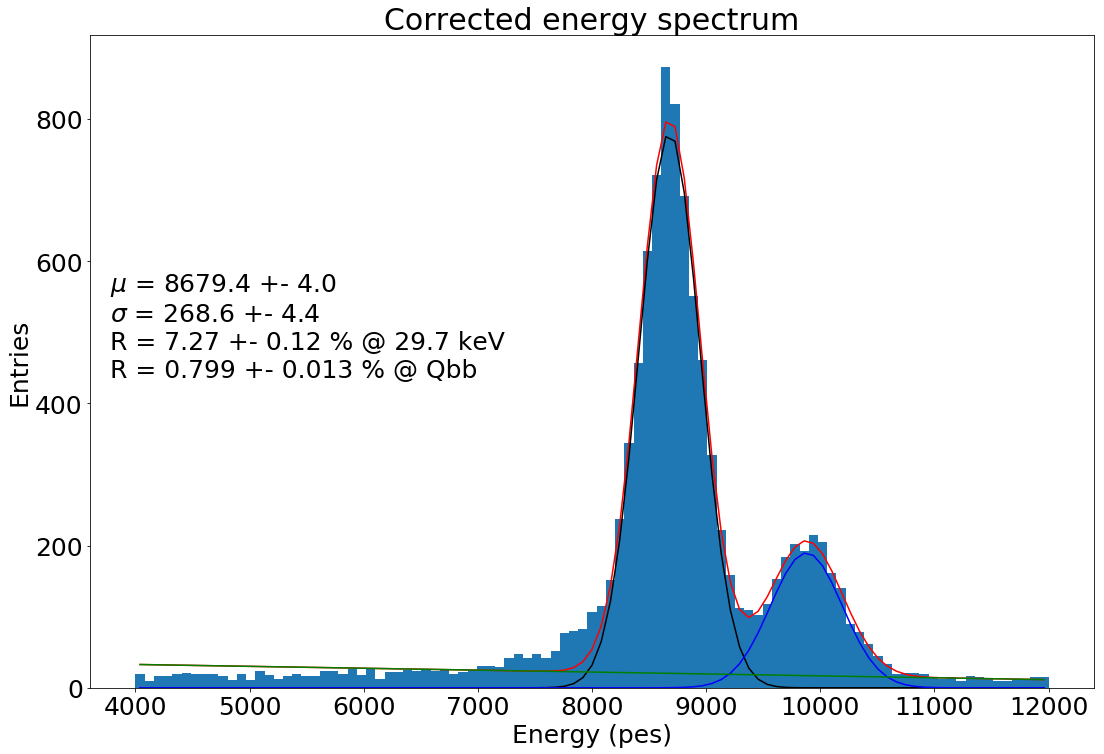

In [11]:
for n_rebin in rebin_values:
    E        = Ecorr[n_rebin]
    y, x, _  = hist(E, XR_range_bins)

    fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                            fitf.gauss  (x, *args[3:6]) + \
                            fitf.polynom(x, *args[6: ])
    
    ndat = np.sum(y)
    seed = ndat    , XR1_fit_seed    , XR1_fit_seed*0.03, ndat    , XR2_fit_seed    , XR2_fit_seed*0.03,  np.mean(y)/10, -1e-2
    low  = ndat/1e2, XR1_fit_seed*0.9, XR1_fit_seed*0.01, ndat/100, XR2_fit_seed*0.9, XR2_fit_seed*0.01, -np.mean(y)   , -1e+1
    upp  = ndat*1e2, XR1_fit_seed*1.1, XR1_fit_seed*0.06, ndat*100, XR2_fit_seed*1.1, XR2_fit_seed*0.06,  np.mean(y)   , +1e+1

    f = fitf.fit(fun, x, y, seed, fit_range=XR_fit_range, sigma=poisson_sigma(y), bounds=(low, upp))
    assert not np.any(np.isclose(f.values, seed)), np.isclose(f.values, seed)
    assert not np.any(np.isclose(f.values, low) ), np.isclose(f.values, low )
    assert not np.any(np.isclose(f.values, upp) ), np.isclose(f.values, upp )

    plt.plot(x, f   .fn     (x                ), global_fit_draw_opt)
    plt.plot(x, fitf.gauss  (x, *f.values[ :3]), peak_1_fit_draw_opt)
    plt.plot(x, fitf.gauss  (x, *f.values[3:6]), peak_2_fit_draw_opt)
    plt.plot(x, fitf.polynom(x, *f.values[6: ]),    bkg_fit_draw_opt)
    plt.text(plt.xlim()[0] * 1.05, np.max(y)/2,
             gausstext(f.values, f.errors, XR1_energy_keV))
    
    reso = resolution(f.values, f.errors, XR1_energy_keV)
    print(resolution_at_xr_string , measurement_string(*reso[0]))
    print(resolution_at_qbb_string, measurement_string(*reso[1]))
    print(             chi2_string, f.chi2)

    resolution_xr  [n_rebin] = reso[1].value
    u_resolution_xr[n_rebin] = reso[1].uncertainty

    plt.ylim(0)
    labels("Energy (pes)", "Entries", "Corrected energy spectrum")
    save("22Na_XR_spectrum_{}mm_rebin{}".format(corr_pitch, n_rebin))

# Photopeak

Resolution at 511  keV: 2.256 +- 0.054
Resolution at 2458 keV: 1.028 +- 0.025
Chi2                  : 1.9235687724
Resolution at 511  keV: 2.252 +- 0.047
Resolution at 2458 keV: 1.027 +- 0.021
Chi2                  : 1.26477215981
Resolution at 511  keV: 2.266 +- 0.051
Resolution at 2458 keV: 1.033 +- 0.023
Chi2                  : 1.68275346967
Resolution at 511  keV: 2.267 +- 0.051
Resolution at 2458 keV: 1.034 +- 0.023
Chi2                  : 1.73034683411
Resolution at 511  keV: 2.253 +- 0.052
Resolution at 2458 keV: 1.027 +- 0.023
Chi2                  : 1.74682632
Resolution at 511  keV: 2.255 +- 0.047
Resolution at 2458 keV: 1.028 +- 0.021
Chi2                  : 1.6692389855
Resolution at 511  keV: 2.230 +- 0.053
Resolution at 2458 keV: 1.017 +- 0.024
Chi2                  : 1.33426620764
Resolution at 511  keV: 2.300 +- 0.050
Resolution at 2458 keV: 1.049 +- 0.023
Chi2                  : 2.59714407905
Resolution at 511  keV: 2.288 +- 0.050
Resolution at 2458 keV: 1.043 +- 0.023

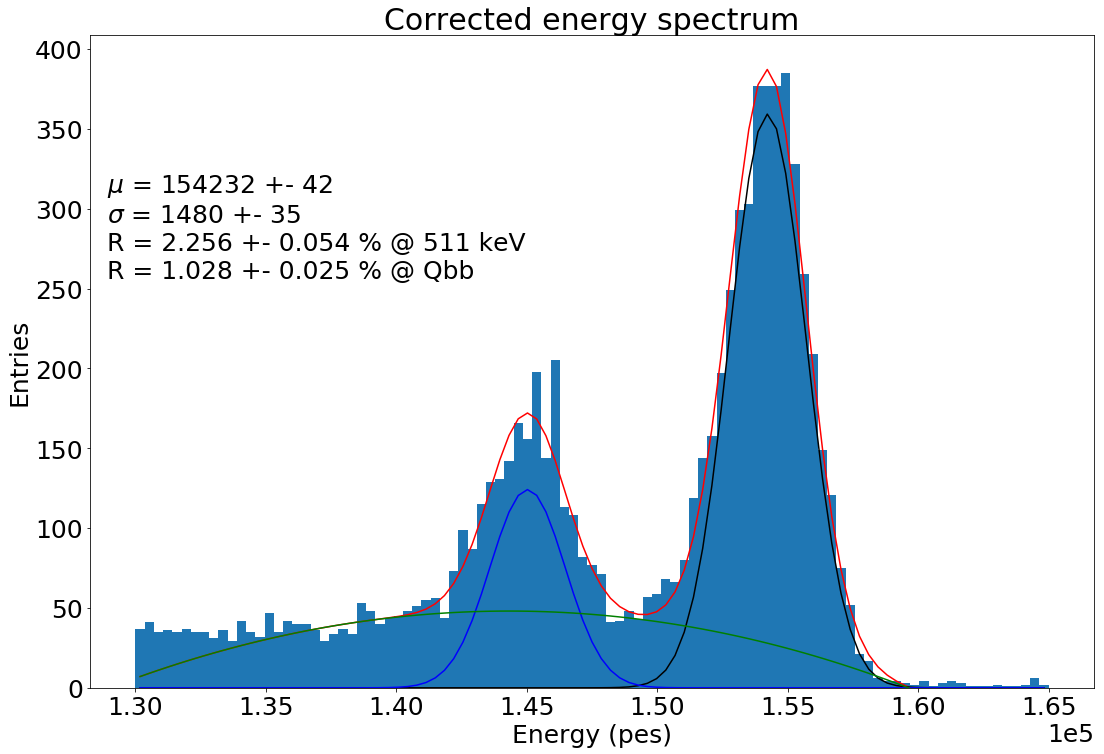

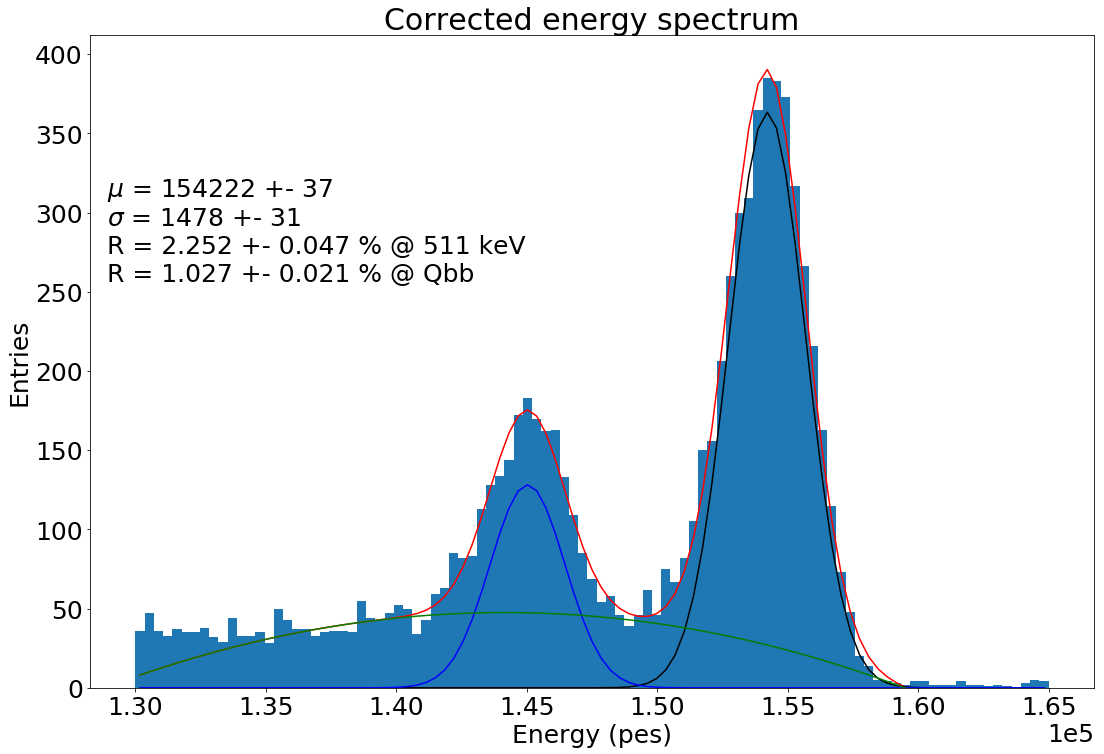

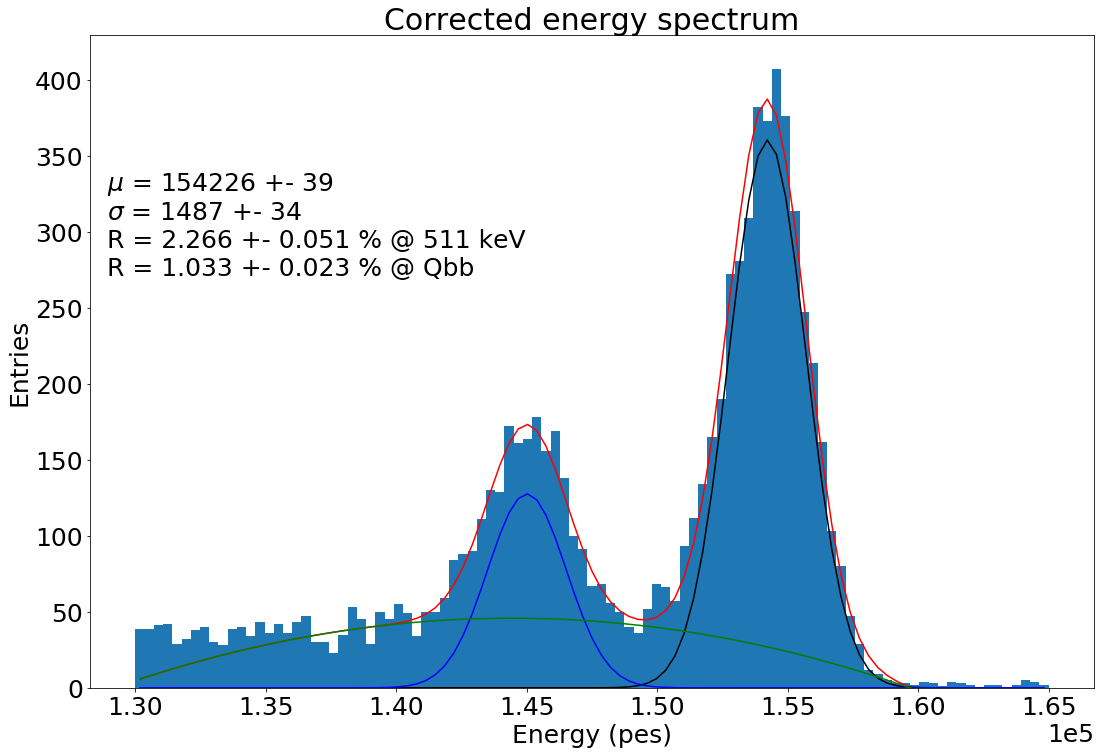

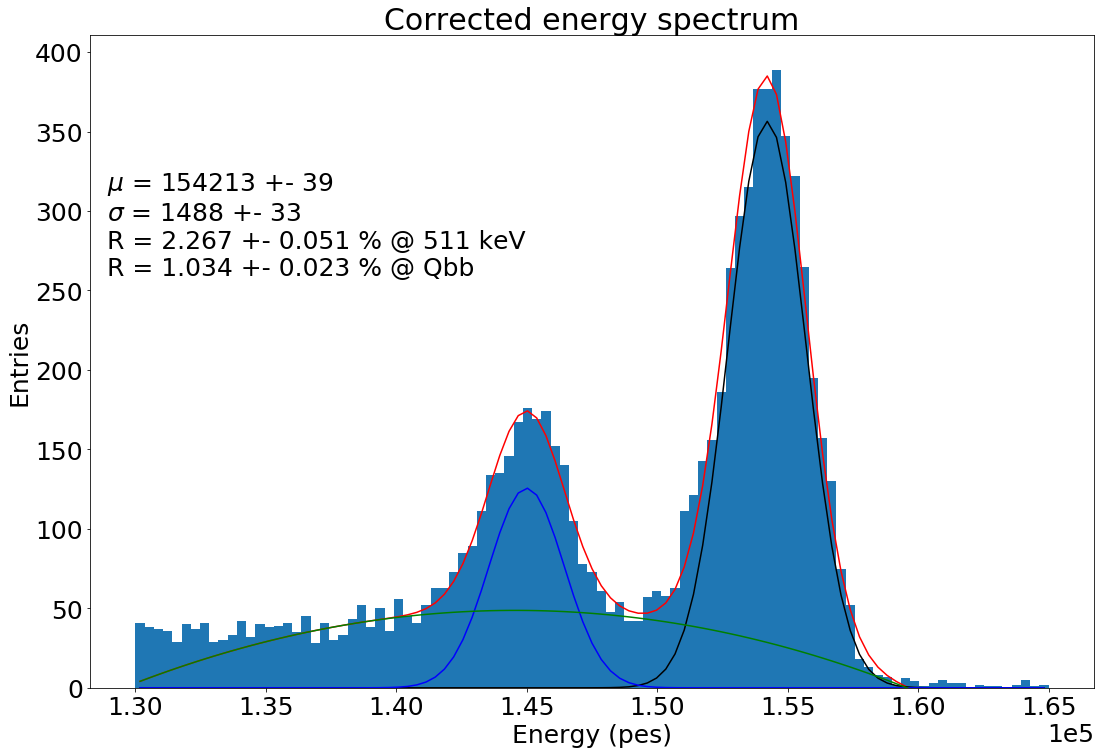

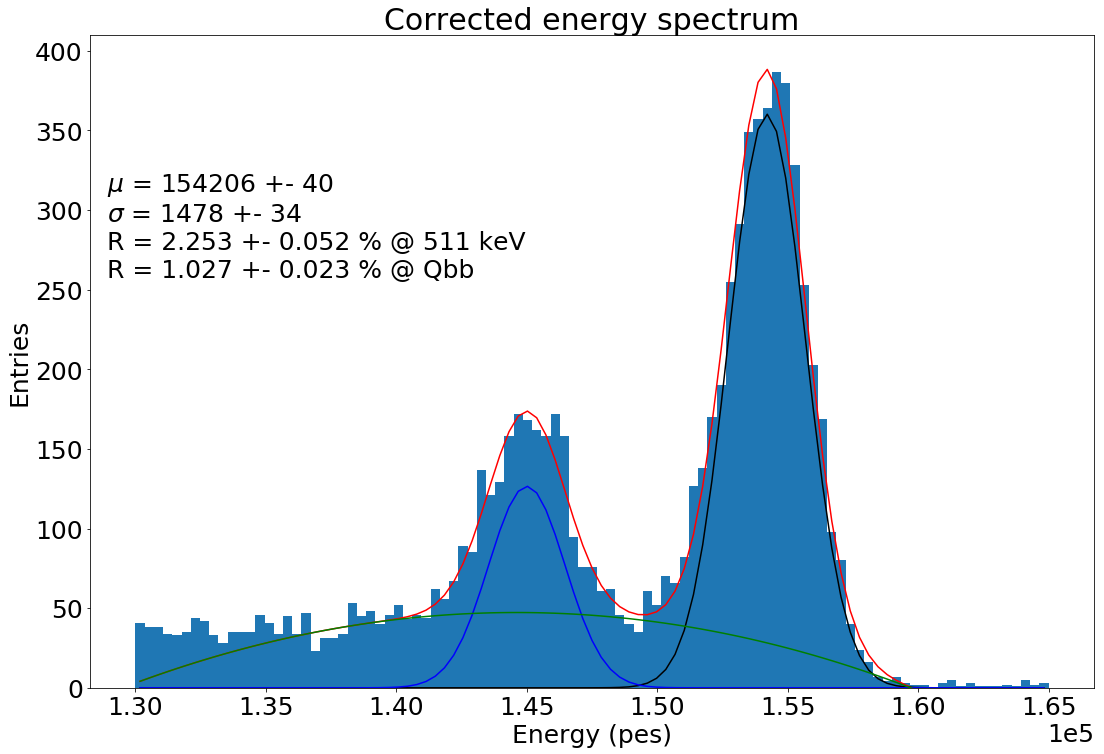

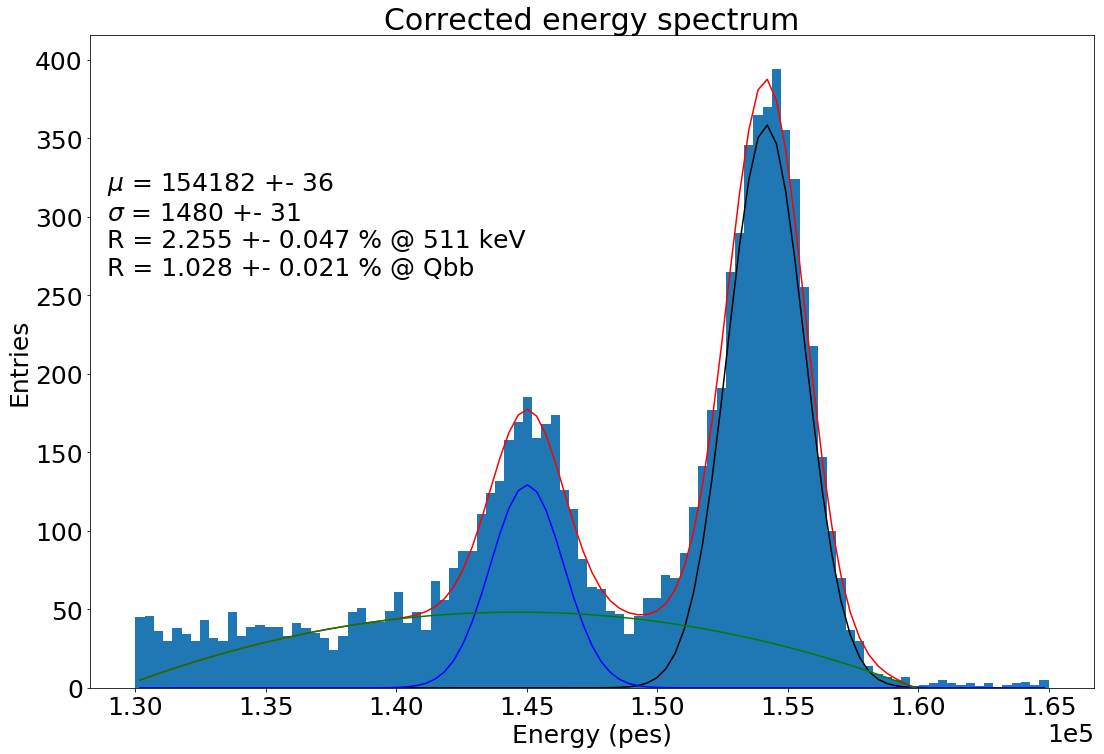

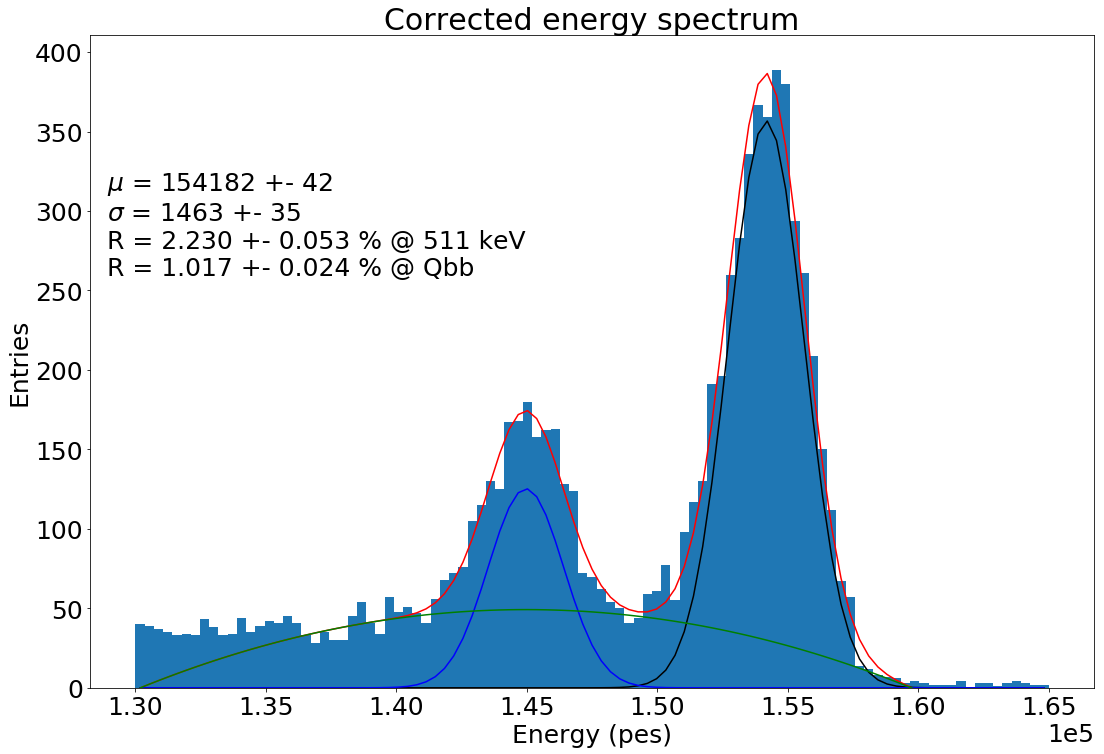

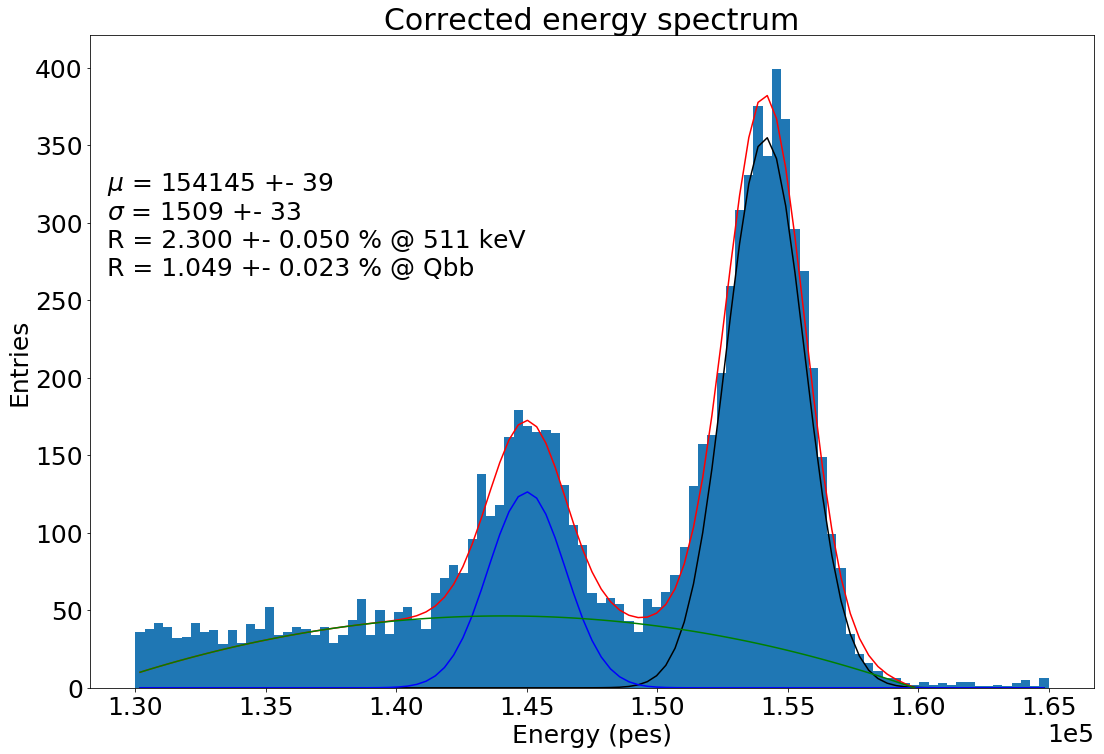

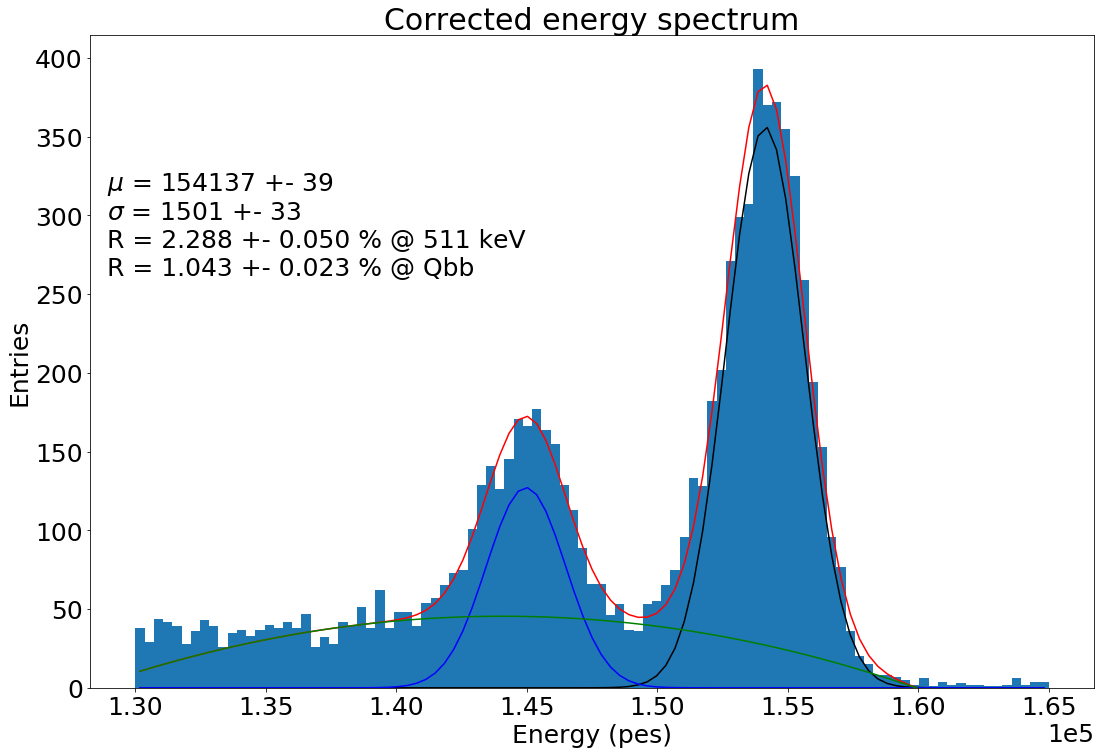

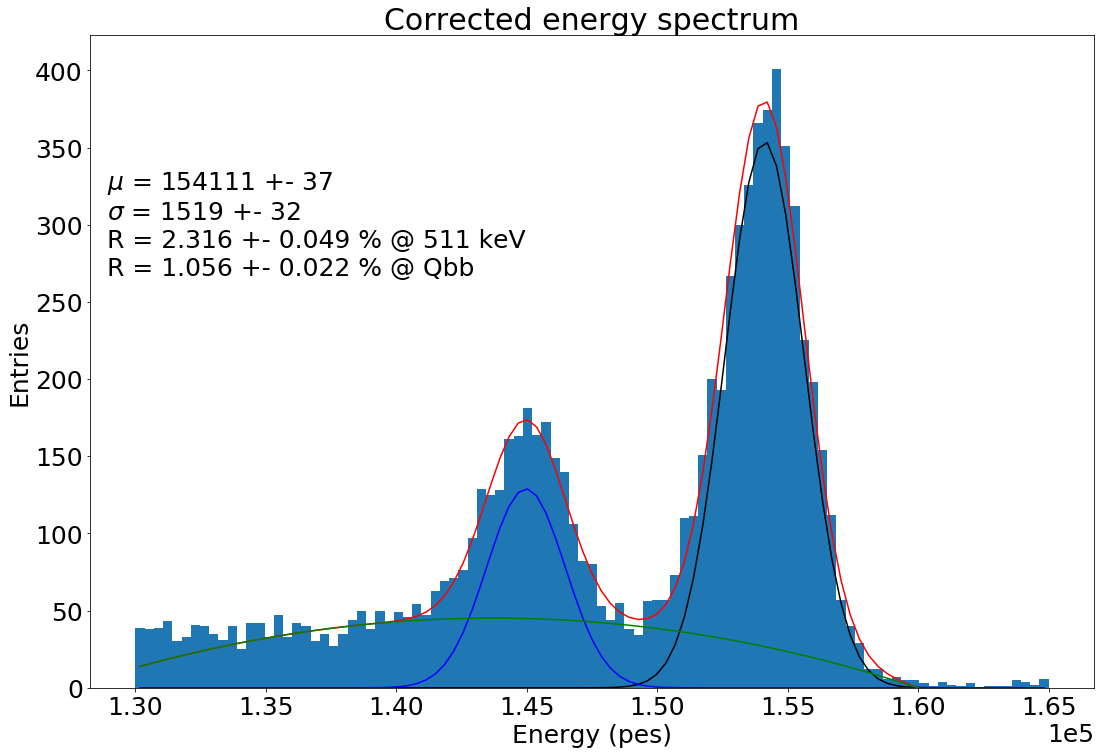

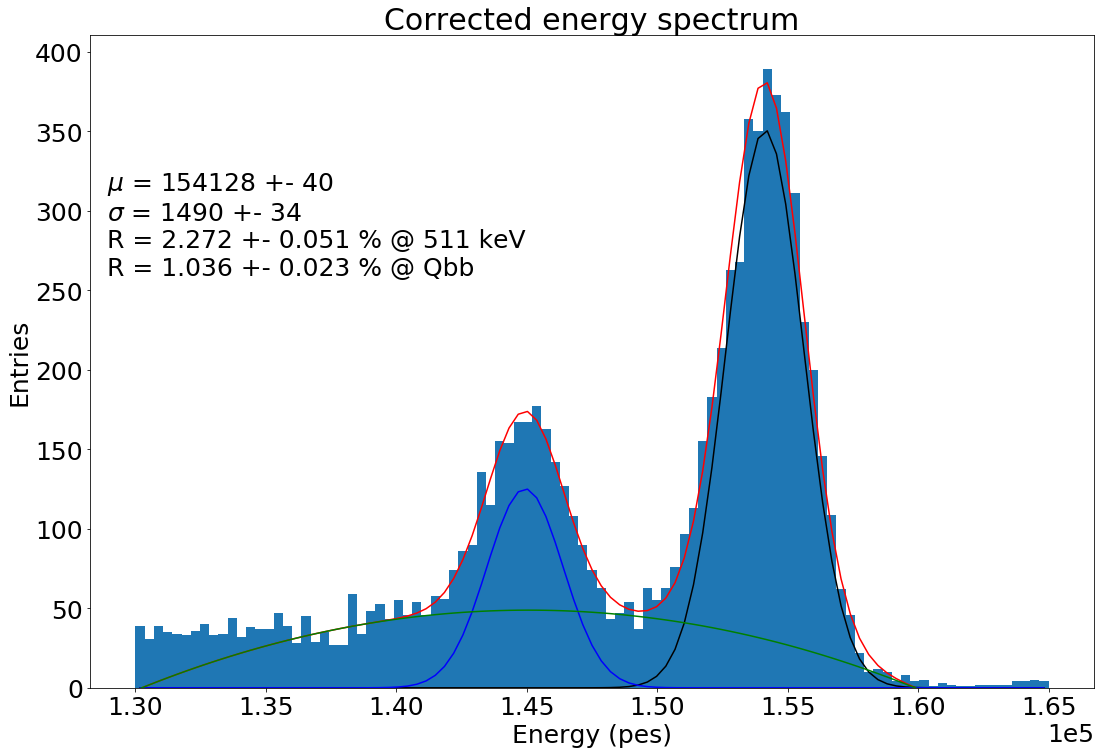

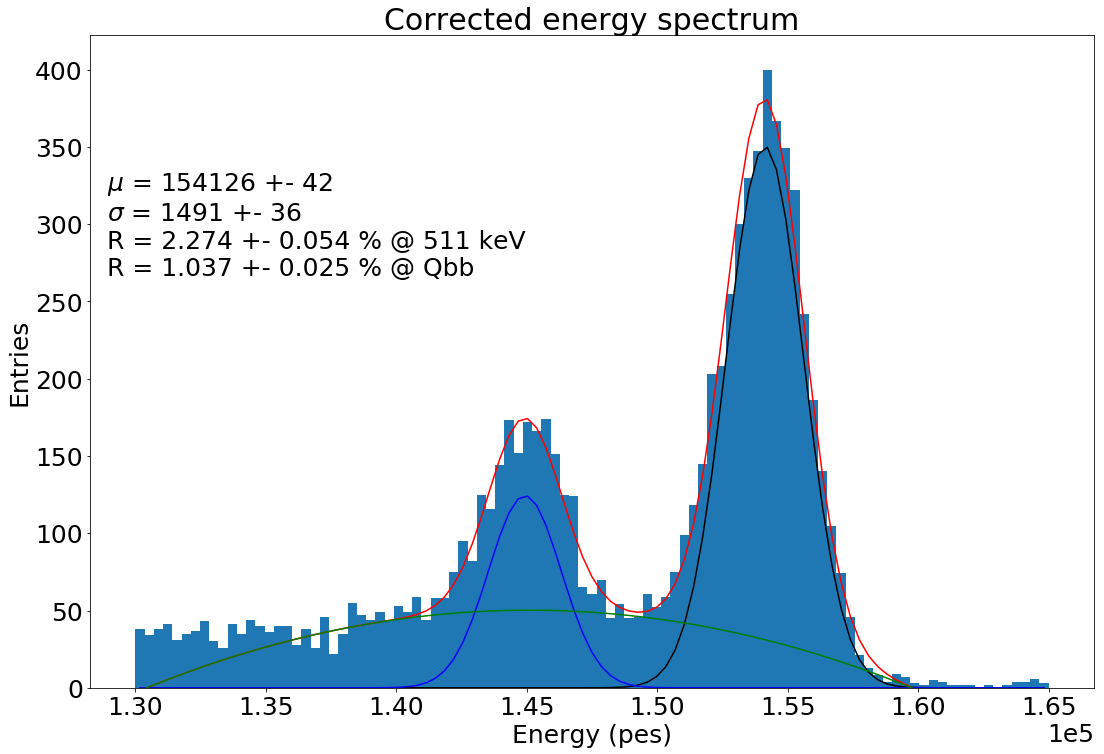

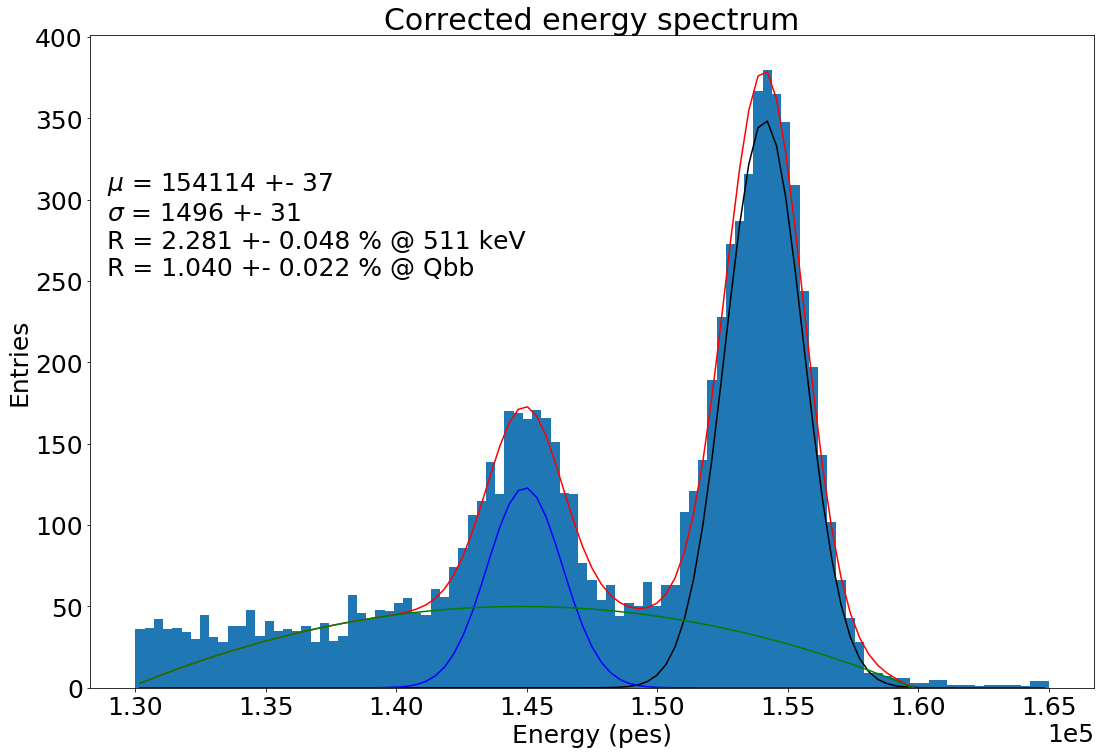

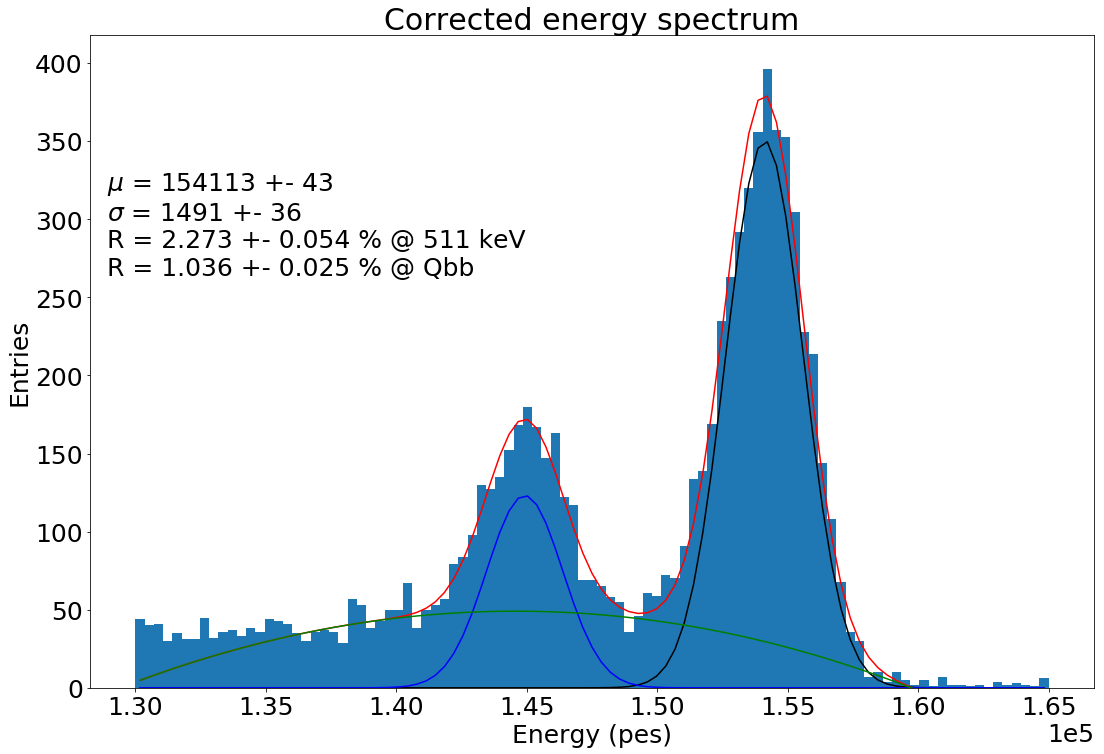

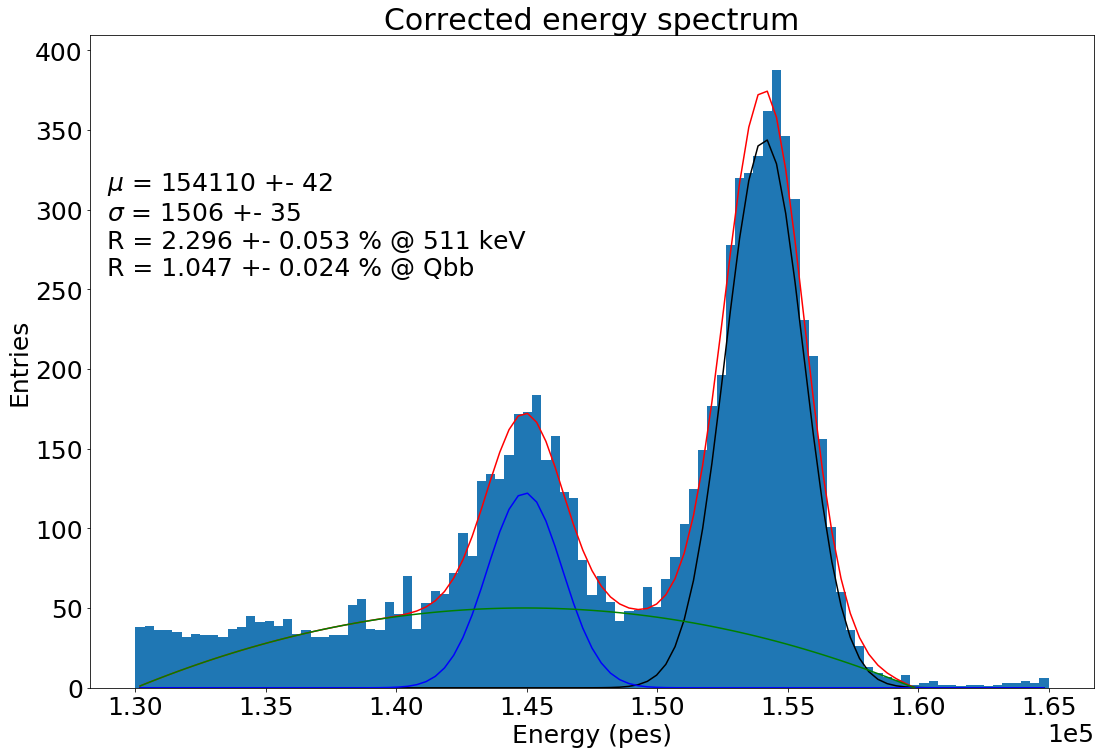

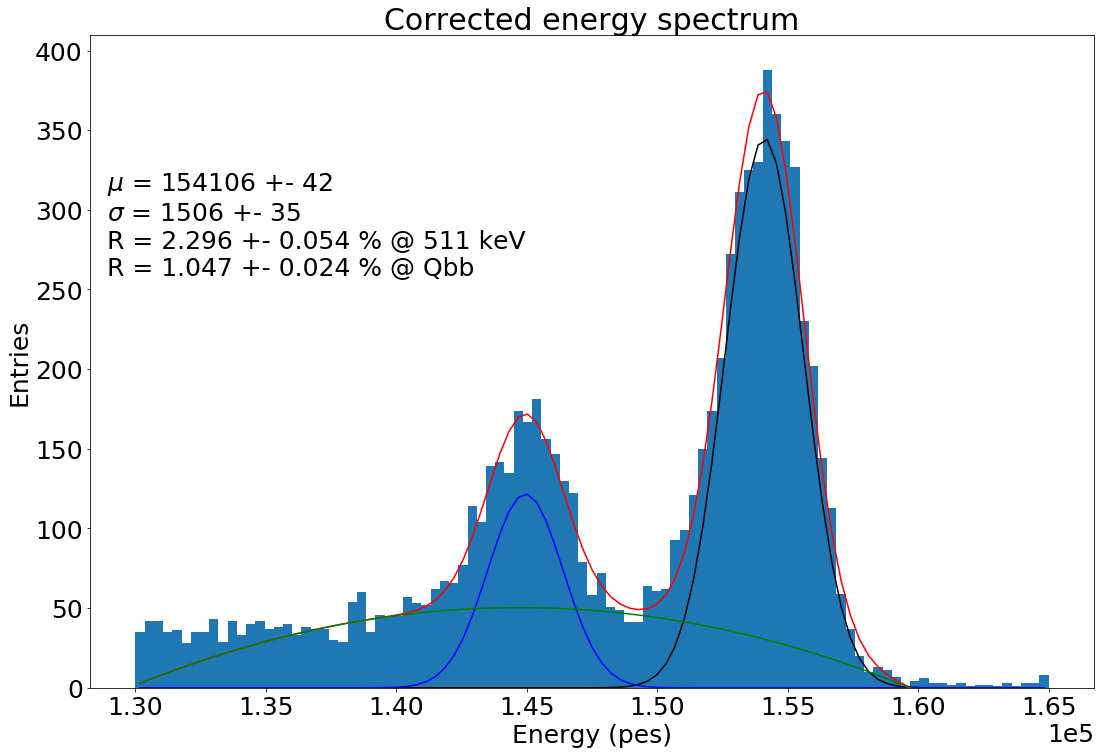

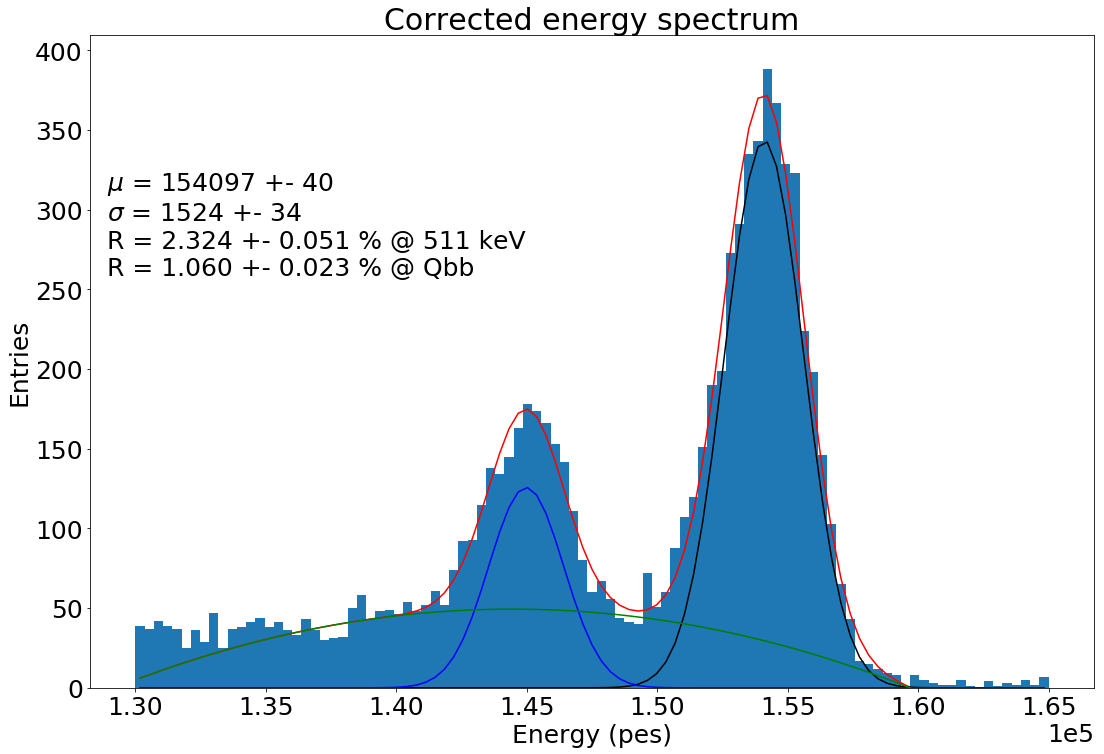

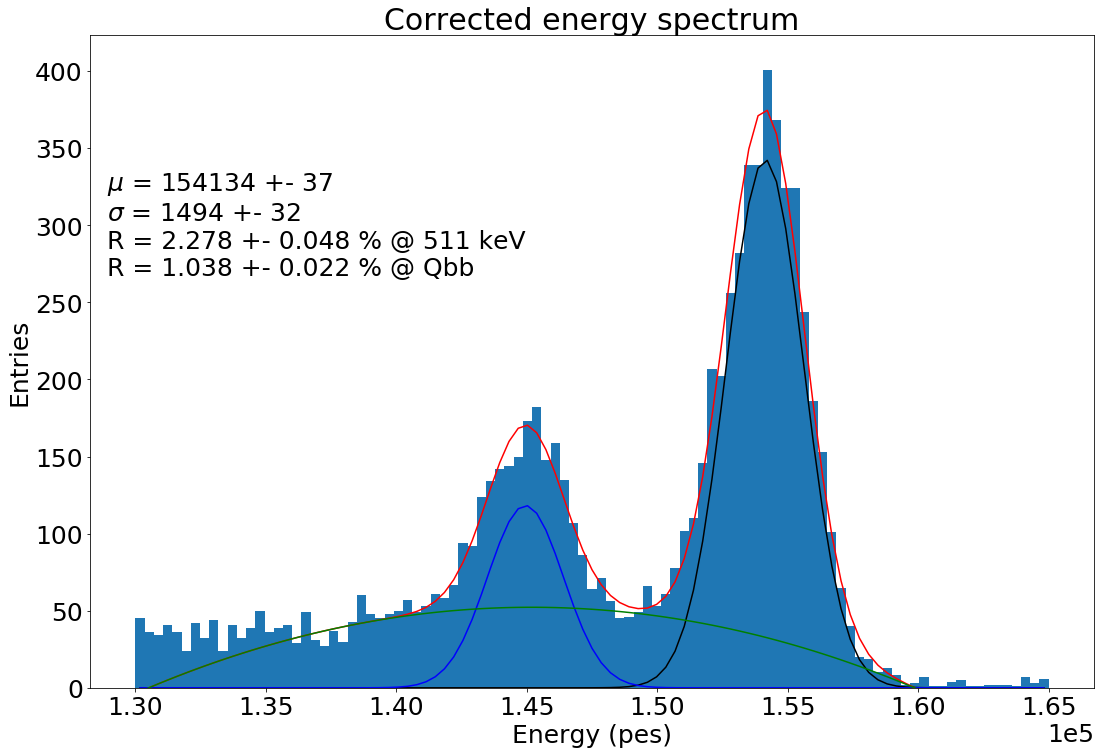

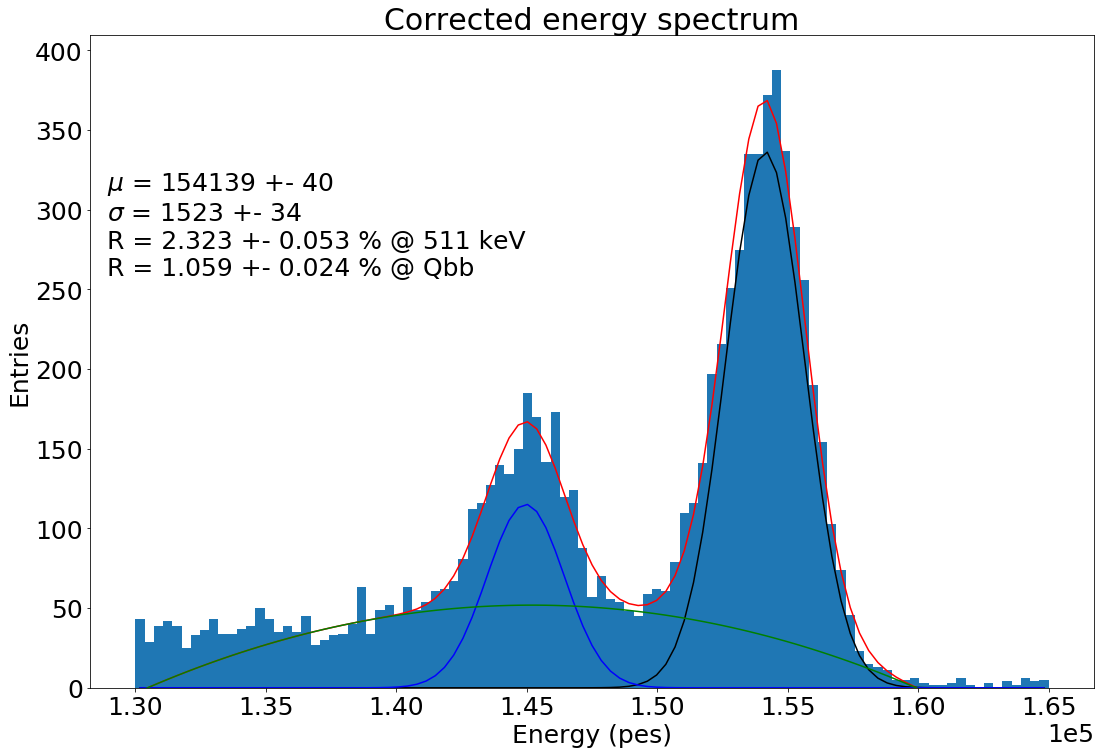

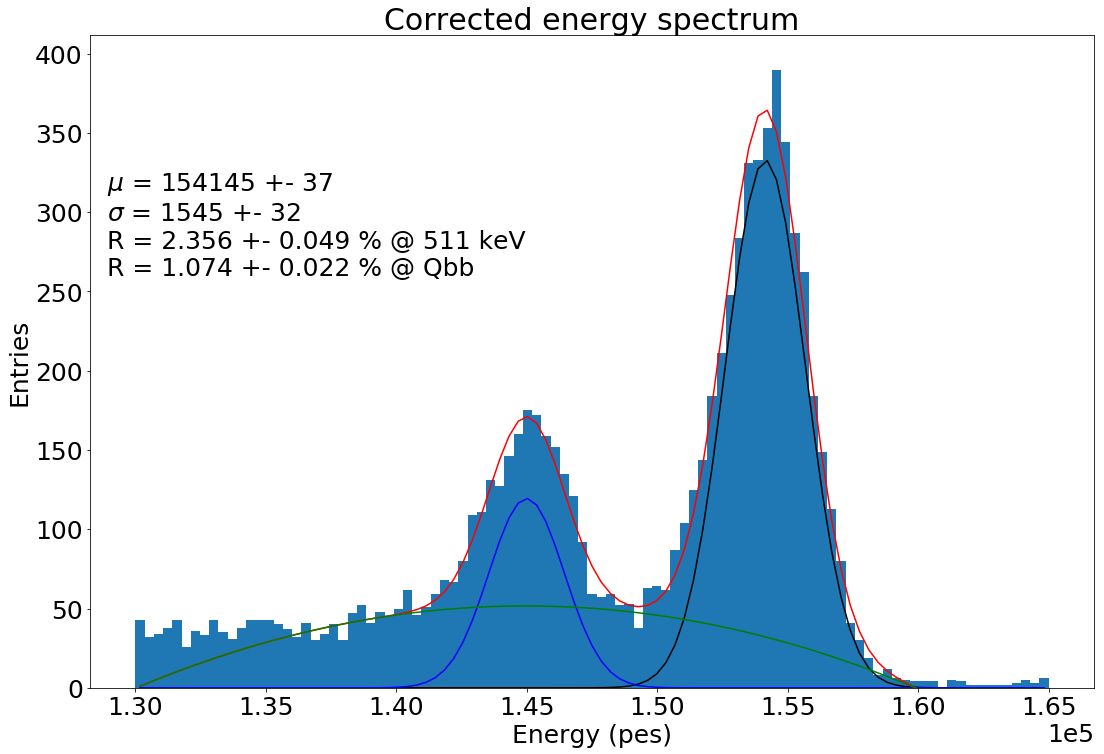

In [12]:
for n_rebin in rebin_values:
    E        = Ecorr[n_rebin]
    y, x, _  = hist(E, PP_range_bins)

    fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                            fitf.gauss  (x, *args[3:6]) + \
                            fitf.polynom(x, *args[6: ])

    ndat = np.sum(y)
    seed = ndat    , PP1_fit_seed     , PP1_fit_seed*0.010, ndat    , PP2_fit_seed     , PP2_fit_seed*0.010, -1e3, 1e-2, -1e-7
    low  = ndat/1e2, PP1_fit_seed*0.99, PP1_fit_seed*0.003, ndat/1e2, PP2_fit_seed*0.99, PP2_fit_seed*0.003, -1e5,    0, -1e-1
    upp  = ndat*1e4, PP1_fit_seed*1.01, PP1_fit_seed*0.020, ndat*1e4, PP2_fit_seed*1.01, PP2_fit_seed*0.020,    0, 1e+3,     0

    f = fitf.fit(fun, x, y, seed, fit_range=PP_fit_range, sigma=poisson_sigma(y), bounds=(low, upp))

    assert not np.any(np.isclose(f.values, seed)), np.isclose(f.values, seed)
    assert not np.any(np.isclose(f.values, low) ), np.isclose(f.values, low )
    assert not np.any(np.isclose(f.values, upp) ), np.isclose(f.values, upp )

    plt.plot(x, f   .fn     (x                ), global_fit_draw_opt)
    plt.plot(x, fitf.gauss  (x, *f.values[ :3]), peak_1_fit_draw_opt)
    plt.plot(x, fitf.gauss  (x, *f.values[3:6]), peak_2_fit_draw_opt)
    plt.plot(x, fitf.polynom(x, *f.values[6: ]),    bkg_fit_draw_opt)
    plt.text(plt.xlim()[0] * 1.005, np.max(y)/1.5,
             gausstext(f.values, f.errors, PP1_energy_keV))

    reso = resolution(f.values, f.errors, PP1_energy_keV)
    print(resolution_at_pp_string , measurement_string(*reso[0]))
    print(resolution_at_qbb_string, measurement_string(*reso[1]))
    print(             chi2_string, f.chi2)

    resolution_pp  [n_rebin] = reso[1].value
    u_resolution_pp[n_rebin] = reso[1].uncertainty

    plt.ylim(0)
    plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
    labels("Energy (pes)", "Entries", "Corrected energy spectrum")
    save("22Na_photopeak_spectrum_{}mm_rebin{}".format(corr_pitch, n_rebin))

# Resolution vs slice size

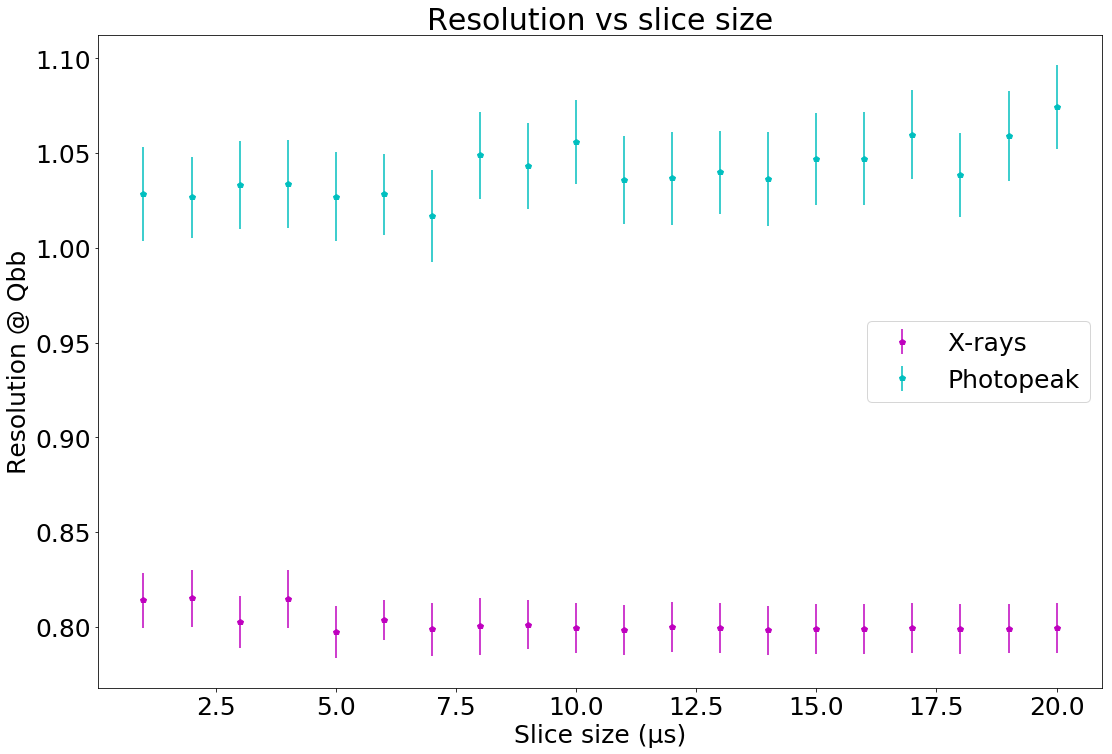

In [13]:
xr   = np.array([  resolution_xr[r] for r in rebin_values])
u_xr = np.array([u_resolution_xr[r] for r in rebin_values])
pp   = np.array([  resolution_pp[r] for r in rebin_values])
u_pp = np.array([u_resolution_pp[r] for r in rebin_values])

plt.errorbar(rebin_values, xr, u_xr, fmt=data1_draw_opt, label="X-rays")
plt.errorbar(rebin_values, pp, u_pp, fmt=data2_draw_opt, label="Photopeak")
plt.legend(loc="center right")

labels("Slice size (µs)", "Resolution @ Qbb", "Resolution vs slice size")

# OLD STUFF